In [1]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
!ls /opt/conda/lib/python3.10/site-packages/fsspec*

/opt/conda/lib/python3.10/site-packages/fsspec:
__init__.py  caching.py      core.py	    gui.py	     spec.py
__pycache__  callbacks.py    dircache.py    implementations  tests
_version.py  compression.py  exceptions.py  mapping.py	     transaction.py
archive.py   config.py	     fuse.py	    parquet.py	     utils.py
asyn.py      conftest.py     generic.py     registry.py

/opt/conda/lib/python3.10/site-packages/fsspec-2023.6.0.dist-info:
INSTALLER  METADATA  REQUESTED	direct_url.json
LICENSE    RECORD    WHEEL	top_level.txt


In [3]:
%pip install faiss-cpu

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install fsspec==2023.6.0

Note: you may need to restart the kernel to use updated packages.


In [5]:
!ls /opt/conda/lib/python3.10/site-packages/fsspec*

/opt/conda/lib/python3.10/site-packages/fsspec:
__init__.py  caching.py      core.py	    gui.py	     spec.py
__pycache__  callbacks.py    dircache.py    implementations  tests
_version.py  compression.py  exceptions.py  mapping.py	     transaction.py
archive.py   config.py	     fuse.py	    parquet.py	     utils.py
asyn.py      conftest.py     generic.py     registry.py

/opt/conda/lib/python3.10/site-packages/fsspec-2023.6.0.dist-info:
INSTALLER  METADATA  REQUESTED	direct_url.json
LICENSE    RECORD    WHEEL	top_level.txt


In [6]:
#!mv /opt/conda/lib/python3.10/site-packages/fsspec-2023.6.0.dist-info/ mm/


In [7]:
!ls /opt/conda/lib/python3.10/site-packages/fsspec-2023.6.0.dist-info/

INSTALLER  METADATA  REQUESTED	direct_url.json
LICENSE    RECORD    WHEEL	top_level.txt


In [8]:
%pip install accelerate==0.27.2
%pip install sentence-transformers
%pip install awswrangler
%pip install --upgrade sentence_transformers

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
#%pip install --force-reinstall --no-deps fsspec==2023.6.0


### Download model

In [11]:
import boto3
import os

def download_s3_folder(bucket_name, s3_folder, local_path):
    """
    Download a folder (or "prefix") from S3 to the local filesystem.
    """
    s3 = boto3.client('s3')
    paginator = s3.get_paginator('list_objects_v2')
    for result in paginator.paginate(Bucket=bucket_name, Prefix=s3_folder):
        if 'Contents' in result:
            for key in result['Contents']:
                # Extract file name from S3 key
                key_name = key['Key']
                local_file_path = os.path.join(local_path, os.path.basename(key_name))
                
                # Check if the key represents a folder
                if key_name.endswith('/'):
                    # Create local directory if it doesn't exist
                    os.makedirs(local_file_path, exist_ok=True)
                    # Recursively download folder contents
                    download_s3_folder(bucket_name, key_name, local_file_path)
                else:
                    # Create directory if it doesn't exist
                    os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
                    # Download file
                    try:
                        s3.download_file(bucket_name, key_name, local_file_path)
                    except NotADirectoryError as e:
                        print(f"Skipping file '{key_name}' due to error: {e}")

# Example usage
bucket_name = 'cleo-data-science'
base_name_path = 'model9/checkpoint-2000'
s3_folder = f"transaction_enrichment/experimental_data/caste/pairs_model/{base_name_path}"
local_path = f"/home/sagemaker-user/models/{base_name_path}"

download_s3_folder(bucket_name, s3_folder, local_path)

bucket_name = 'cleo-data-science'
s3_folder = f"transaction_enrichment/experimental_data/caste/pairs_model/{base_name_path}/1_Pooling"
local_path = f"/home/sagemaker-user/models/{base_name_path}/1_Pooling"


download_s3_folder(bucket_name, s3_folder, local_path)


In [12]:
!ls /home/sagemaker-user/models/

model1	model2	model3	model4	model9	model_download


In [13]:
imodel = 9

### Load test data

In [10]:
%pip install awswrangler

Note: you may need to restart the kernel to use updated packages.


In [11]:
import awswrangler as wr
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd

In [12]:
# s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/processed/trans_2024-05-14_2024-05-14"
# s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/"

# df_data_raw= wr.s3.read_parquet(path=s3_path)
# df_data_processed.shape

s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/raw/trans_2024-05-22_2024-05-22"
df_data_raw= wr.s3.read_parquet(path=s3_path)
df_data_raw.shape

(4584212, 28)

In [13]:
df_data_raw.head()

,transaction_id,corrected_made_on,amount,currency_code,description,original_description_plaid,merchant_name,merchant_name_plaid,transaction_type_plaid,counterparty_name,...,category_primary_plaid,payment_channel,payment_method,payment_processor_method,city,region,country,status,decline_code,login_provider_additional_attributes
0,9870111276,2024-05-22,-1.48,USD,Transfer to Savings,Transfer to Savings,Savings,,special,,...,TRANSFER_OUT,other,,,,,,<NA>,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
1,9870111272,2024-05-22,2.95,USD,Transfer from Savings,Transfer from Savings,Savings,,special,,...,TRANSFER_IN,other,,,,,,<NA>,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
2,9870111273,2024-05-22,1.48,USD,Transfer from Spending,Transfer from Spending,Spending,,special,,...,TRANSFER_IN,other,,,,,,<NA>,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
3,9870111278,2024-05-22,-2.95,USD,Transfer to Spending,Transfer to Spending,Spending,,special,,...,TRANSFER_OUT,other,,,,,,<NA>,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
4,9870111270,2024-05-22,20.00,USD,On-Demand Pay Advance,On-Demand Pay Advance,On Demand,,special,,...,TRANSFER_IN,other,,,,,,<NA>,,"{""datetime"": null, ""location"": {""lat"": null, ""..."


In [14]:
keep_cols =['transaction_id','category_primary_plaid','merchant_name','original_description_plaid','description','amount']

In [15]:
df_data_raw = df_data_raw[keep_cols]

In [16]:
df_data_raw = df_data_raw[~df_data_raw['category_primary_plaid'].isin(['TRANSFER_OUT','TRANSFER_IN','LOAN_PAYMENTS','INCOME','BANK_FEES'])]
df_data_raw['len_description'] = df_data_raw['original_description_plaid'].apply(lambda x:len(x))
df_data_raw['merchant_name'] = df_data_raw['merchant_name'].replace('None',None)
df_data_raw['merchant_name'] = df_data_raw['merchant_name'].replace('',None)
df_data_raw['merchant_name'] = df_data_raw['merchant_name'].replace(' ',None)
df_data_raw = df_data_raw.map(lambda x: None if pd.isna(x) else x)
pattern_transfer = r"(Cash\sApp\sTransfer\s[\w\s;]*)"
pattern_cash = r"(Cash\sApp)\s[\w\s;]*"
pattern_apple_cash_transfer = r"(Apple\sCash\sTransfer\s[\w\s;]*)"

df_data_raw['merchant_name'] = df_data_raw['merchant_name'].apply(lambda x: re.sub(pattern_transfer, r"Cash App Transfer", str(x)) if x != None  else None)
df_data_raw['merchant_name'] = df_data_raw['merchant_name'].apply(lambda x: re.sub(pattern_cash, r"Cash App", str(x)) if x != None  else None)
df_data_raw['merchant_name'] = df_data_raw['merchant_name'].apply(lambda x: re.sub(pattern_apple_cash_transfer, r"Apple Cash", str(x)) if x != None  else None)



In [17]:
df_data_raw['description_combined'] = df_data_raw['original_description_plaid'].combine_first(df_data_raw['description'])
df_data_raw['description_combined_processed'] =  df_data_raw['description_combined'].apply(lambda x: re.sub('\\\\+','\\\\',x))
df_data_raw['description_combined_processed'] =  df_data_raw['description_combined_processed'].apply(lambda x: re.sub(r'\d{4,}', ' ', x))
df_data_raw['description_combined_processed'] =  df_data_raw['description_combined_processed'].apply(lambda x: re.sub(r'\d{4,}', ' ', x))
df_data_raw['description_combined_processed'] =  df_data_raw['description_combined_processed'].apply(lambda x: re.sub(r'(.)\1{4,}', ' ', x))
df_data_raw['description_combined_processed'] =  df_data_raw['description_combined_processed'].apply(lambda x: re.sub(' +',' ',x))

In [18]:
df_data_raw_no_merchant = df_data_raw[df_data_raw['merchant_name'].isnull()]
df_data_raw_with_merchant = df_data_raw[~df_data_raw['merchant_name'].isnull()]

In [19]:
print(df_data_raw_no_merchant.shape[0])
print(df_data_raw_with_merchant.shape[0])

91616
1937915


In [20]:
df_data_raw_no_merchant = df_data_raw_no_merchant[df_data_raw_no_merchant['len_description'] >= 3]
df_data_raw_with_merchant = df_data_raw_with_merchant[df_data_raw_with_merchant['len_description'] >= 3]
print(df_data_raw_no_merchant.shape[0])
print(df_data_raw_with_merchant.shape[0])

91613
1930904


In [ ]:
#sample to make faset
df_data_raw_with_merchant = df_data_raw_with_merchant.sample(1000000, random_state=1)

In [ ]:
df_data_raw_with_merchant['category_primary_plaid'].value_counts()

category_primary_plaid
FOOD_AND_DRINK               317924
GENERAL_MERCHANDISE          217715
TRANSPORTATION               175800
ENTERTAINMENT                114138
GENERAL_SERVICES              96316
RENT_AND_UTILITIES            24136
MEDICAL                       17654
PERSONAL_CARE                 15836
TRAVEL                         8077
HOME_IMPROVEMENT               7561
GOVERNMENT_AND_NON_PROFIT      4680
OTHER                           163
Name: count, dtype: int64

In [21]:
df_data_raw_no_merchant.head()

,transaction_id,category_primary_plaid,merchant_name,original_description_plaid,description,amount,len_description,description_combined,description_combined_processed
104,9870525860,ENTERTAINMENT,None,(FIS) FAF_WWW.NCLOTTE FAF_WWW.NCLOTTER 92 LANS...,(FIS) FAF_WWW.NCLOTTE FAF_WWW.NCLOTTER 92 LANS...,100.00,58,(FIS) FAF_WWW.NCLOTTE FAF_WWW.NCLOTTER 92 LANS...,(FIS) FAF_WWW.NCLOTTE FAF_WWW.NCLOTTER 92 LANS...
201,9870662455,GENERAL_MERCHANDISE,None,Purchase #10 Galesburg #6 Galesburg US,Purchase #10 Galesburg #6 Galesburg US,-68.94,49,Purchase #10 Galesburg #6 Galesburg US,Purchase #10 Galesburg #6 Galesburg US
383,9870920485,GOVERNMENT_AND_NON_PROFIT,None,DONATION ROMIELL,DONATION ROMIELL,-25.00,16,DONATION ROMIELL,DONATION ROMIELL
555,9871069670,GENERAL_MERCHANDISE,None,SP CLICKS TECHNOLOGY,SP CLICKS TECHNOLOGY,-159.00,20,SP CLICKS TECHNOLOGY,SP CLICKS TECHNOLOGY
649,9871165272,FOOD_AND_DRINK,None,PELHAM BAY DELI GROC,PELHAM BAY DELI GROC,-45.76,22,PELHAM BAY DELI GROC,PELHAM BAY DELI GROC


In [22]:
df_data_raw_no_merchant['category_primary_plaid'].value_counts()

category_primary_plaid
FOOD_AND_DRINK               27792
TRANSPORTATION               13448
GENERAL_MERCHANDISE          13053
ENTERTAINMENT                12929
GENERAL_SERVICES              9365
RENT_AND_UTILITIES            4032
PERSONAL_CARE                 3749
MEDICAL                       2650
GOVERNMENT_AND_NON_PROFIT     1936
TRAVEL                        1334
HOME_IMPROVEMENT              1128
OTHER                          197
Name: count, dtype: int64

In [ ]:
df_data_raw_no_merchant.head(2)

,transaction_id,category_primary_plaid,merchant_name,original_description_plaid,description,amount,len_description,description_combined,description_combined_processed
989073,9878632619,FOOD_AND_DRINK,Taco Bell,Taco Bell,Taco Bell,-1.08,9,Taco Bell,Taco Bell
1230285,9883864020,ENTERTAINMENT,Betfair,BETFAIR INTERACTIVE US VISA DIRECT FL008596 05/22,BETFAIR INTERACTIVE US VISA DIRECT FL008596 05/22,1900.00,49,BETFAIR INTERACTIVE US VISA DIRECT FL008596 05/22,BETFAIR INTERACTIVE US VISA DIRECT FL 05/22


In [23]:
try:
    del df_data_raw
except:
    pass

# Load embedding model

In [24]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers import SentenceTransformer, InputExample
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from sentence_transformers.losses import CoSENTLoss
from datasets import Dataset
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction
from sentence_transformers import SentenceTransformerTrainer

/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-06-11 04:30:42.123530: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
imodel = 9
istep = 5000
model_name = f"/home/sagemaker-user/models/model{imodel}/checkpoint-{istep}"
model = SentenceTransformer(model_name)

In [26]:
import sentence_transformers
from sentence_transformers.evaluation import TripletEvaluator, BinaryClassificationEvaluator

In [27]:
text_column =  "description_combined_processed"

In [29]:
import torch

In [31]:
def get_tx_description_embeddings(model, df, text_column, batch_size_preds):
    batch_size = batch_size_preds
    all_embeddings = empty_array = np.empty((0, 768))

    for istart in np.arange(0, df.shape[0]+1, batch_size):
        iend = min(df.shape[0],istart + batch_size)
        if iend> istart:
            print(istart, iend)
            tx_embeddings = model.encode(df[text_column][istart:iend].tolist())
            all_embeddings = np.concatenate((all_embeddings, tx_embeddings), axis=0)
            #df.loc[istart:iend-1,'tx_embedding'] =  tx_embeddings
    
    # Convert the numpy array into a list of arrays (or lists)
    embeddings_as_lists = [all_embeddings[i, :] for i in range(all_embeddings.shape[0])]

    # Create a DataFrame and assign the list of arrays to a single column
    df_embeddings = pd.DataFrame({text_column+'_embedding': embeddings_as_lists})
    df_embeddings['transaction_id'] = df['transaction_id']
    df_embeddings[text_column] = df[text_column]
    df_embeddings['merchant_name'] = ""
    try:
        df_embeddings['merchant_name'] = df['merchant_name']
    except:
        pass
    
    return df_embeddings    

In [48]:
batch_size_preds = 5000
df_data_raw_no_merchant.reset_index(drop=True, inplace=True)
all_embeddings_1 = get_tx_description_embeddings(model, df_data_raw_no_merchant, text_column, batch_size_preds)

0 5000
5000 10000
10000 15000
15000 20000
20000 25000
25000 30000
30000 35000
35000 40000
40000 45000
45000 50000
50000 55000
55000 60000
60000 65000
65000 70000
70000 75000
75000 80000
80000 85000
85000 90000
90000 91613


In [49]:
all_embeddings_1.head()

,description_combined_processed_embedding,transaction_id,description_combined_processed,merchant_name
0,"[-0.09991075098514557, -0.20930267870426178, 0...",9870525860,(FIS) FAF_WWW.NCLOTTE FAF_WWW.NCLOTTER 92 LANS...,None
1,"[-0.41577568650245667, 0.606635570526123, 0.02...",9870662455,Purchase #10 Galesburg #6 Galesburg US,None
2,"[0.07951699942350388, -0.04787381365895271, 0....",9870920485,DONATION ROMIELL,None
3,"[-0.08092399686574936, 0.678030252456665, 1.09...",9871069670,SP CLICKS TECHNOLOGY,None
4,"[0.09376141428947449, 0.0005073878564871848, -...",9871165272,PELHAM BAY DELI GROC,None


In [50]:
df_data_raw_no_merchant[['transaction_id',text_column]]

,transaction_id,description_combined_processed
0,9870525860,(FIS) FAF_WWW.NCLOTTE FAF_WWW.NCLOTTER 92 LANS...
1,9870662455,Purchase #10 Galesburg #6 Galesburg US
2,9870920485,DONATION ROMIELL
3,9871069670,SP CLICKS TECHNOLOGY
4,9871165272,PELHAM BAY DELI GROC
...,...,...
91608,9887162684,POS Debit - Visa Check Card - WALMART COM AMBE...
91609,10038366869,Debit Purchase -visa Law Off. Crispin Ca 05/21...
91610,9882645862,POS Debit - Visa Check Card - CHICK-FIL-A DOUG...
91611,9882645863,POS Debit - Visa Check Card - DUNKIN DOUGLASVI...


In [51]:
#save embeddings in output file 
print(s3_path.split('/raw/')[1])

#s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/raw/trans_2024-05-22_2024-05-22"


trans_2024-05-22_2024-05-22


In [40]:
df_data_raw_no_merchant.head()

,transaction_id,category_primary_plaid,merchant_name,original_description_plaid,description,amount,len_description,description_combined,description_combined_processed
104,9870525860,ENTERTAINMENT,None,(FIS) FAF_WWW.NCLOTTE FAF_WWW.NCLOTTER 92 LANS...,(FIS) FAF_WWW.NCLOTTE FAF_WWW.NCLOTTER 92 LANS...,100.00,58,(FIS) FAF_WWW.NCLOTTE FAF_WWW.NCLOTTER 92 LANS...,(FIS) FAF_WWW.NCLOTTE FAF_WWW.NCLOTTER 92 LANS...
201,9870662455,GENERAL_MERCHANDISE,None,Purchase #10 Galesburg #6 Galesburg US,Purchase #10 Galesburg #6 Galesburg US,-68.94,49,Purchase #10 Galesburg #6 Galesburg US,Purchase #10 Galesburg #6 Galesburg US
383,9870920485,GOVERNMENT_AND_NON_PROFIT,None,DONATION ROMIELL,DONATION ROMIELL,-25.00,16,DONATION ROMIELL,DONATION ROMIELL
555,9871069670,GENERAL_MERCHANDISE,None,SP CLICKS TECHNOLOGY,SP CLICKS TECHNOLOGY,-159.00,20,SP CLICKS TECHNOLOGY,SP CLICKS TECHNOLOGY
649,9871165272,FOOD_AND_DRINK,None,PELHAM BAY DELI GROC,PELHAM BAY DELI GROC,-45.76,22,PELHAM BAY DELI GROC,PELHAM BAY DELI GROC


In [52]:
s3_path_out_embeddings = f"s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model{imodel}/checkpoint-{istep}/no_merchant_embeddings_{s3_path.split('/raw/')[1]}.parquet"
s3_path_out_data_no_merchant = f"s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model{imodel}/checkpoint-{istep}/no_merchant_{s3_path.split('/raw/')[1]}.parquet"
print(s3_path_out_embeddings)
print(s3_path_out_data_no_merchant)

s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/no_merchant_embeddings_trans_2024-05-22_2024-05-22.parquet
s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/no_merchant_trans_2024-05-22_2024-05-22.parquet


In [53]:
wr.s3.to_parquet(
        df=df_data_raw_no_merchant,
        path=s3_path_out_data_no_merchant,
        dataset=True #,partition_cols=["merchant_name_combined"]
    )

print(f"Finsihed writing file {s3_path_out_data_no_merchant}")


Finsihed writing file s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/no_merchant_trans_2024-05-22_2024-05-22.parquet


In [55]:
wr.s3.to_parquet(
        df=all_embeddings_1,
        path=s3_path_out_embeddings,
        dataset=True #,partition_cols=["merchant_name_combined"]
    )

print(f"Finsihed writing file {s3_path_out_embeddings}")

Finsihed writing file s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/no_merchant_embeddings_trans_2024-05-22_2024-05-22.parquet


In [39]:
all_embeddings_1

,description_combined_processed_embedding,transaction_id,description_combined_processed,merchant_name
0,"[-0.09991075098514557, -0.20930267870426178, 0...",NaN,NaN,NaN
1,"[-0.41577568650245667, 0.606635570526123, 0.02...",NaN,NaN,NaN
2,"[0.07951699942350388, -0.04787381365895271, 0....",NaN,NaN,NaN
3,"[-0.08092399686574936, 0.678030252456665, 1.09...",NaN,NaN,NaN
4,"[0.09376141428947449, 0.0005073878564871848, -...",NaN,NaN,NaN
...,...,...,...,...
91608,"[0.6595080494880676, -0.5811120271682739, 0.74...",NaN,NaN,NaN
91609,"[0.060604047030210495, -0.3523649573326111, 0....",NaN,NaN,NaN
91610,"[0.17883697152137756, 0.07259216159582138, -0....",NaN,NaN,NaN
91611,"[-0.49968644976615906, 0.1489555686712265, -0....",NaN,NaN,NaN


# FINISH

In [2]:
# load file to make sure everything is working
import awswrangler as wr
path_out = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/with_merchant_embeddings_trans_2024-05-22_2024-05-22.parquet"
df_embeddings_load= wr.s3.read_parquet(path=path_out)
print(df_embeddings_load.shape)
df_embeddings_load.head()

(1000000, 4)


,description_combined_processed_embedding,transaction_id,description_combined_processed,merchant_name
0,"[-0.0872960239648819, 0.5050700902938843, -0.1...",9878632619,Taco Bell,Taco Bell
1,"[-0.23462337255477905, -1.032484531402588, -0....",9883864020,BETFAIR INTERACTIVE US VISA DIRECT FL 05/22,Betfair
2,"[0.9711945056915283, -0.42020517587661743, -0....",9894520172,7-ELEVEN 05/21 # MOBILE PURCHASE 7-ELEVEN Alex...,7 Eleven
3,"[0.031672872602939606, 0.8014014363288879, -0....",9898004363,PURCHASE AUTHORIZED ON 05/22 KING SOOP S. COLL...,King Soopers
4,"[-0.760118305683136, -0.8001836538314819, 0.42...",9882113396,Purchase ABSOLUTE LIQOURS NORTH MIAMI BFLUS,Absolute Liqours


In [113]:

# Convert the numpy array into a list of arrays (or lists)
embeddings_as_lists = [all_embeddings_1[i, :] for i in range(all_embeddings_1.shape[0])]

# Create a DataFrame and assign the list of arrays to a single column
df_embeddings = pd.DataFrame({text_column+'_embedding': embeddings_as_lists})
df_embeddings

,description_combined_processed_embedding
0,"[1.2812663316726685, -0.4901178181171417, 0.77..."
1,"[-0.45065268874168396, -0.13476717472076416, -..."
2,"[0.04087890312075615, 0.25581154227256775, 0.3..."
3,"[0.2949807047843933, 0.11329221725463867, -0.4..."
4,"[0.5704224109649658, 0.31651610136032104, 0.25..."
...,...
9995,"[0.08810721337795258, 0.7716650366783142, -0.3..."
9996,"[-0.5394763350486755, 0.8464439511299133, 0.65..."
9997,"[-0.5394763350486755, 0.8464439511299133, 0.65..."
9998,"[0.47760382294654846, 0.07342730462551117, 0.2..."


In [36]:
def do_predictions(model, df, text_column, batch_size_preds, embeddings_merchants):
    batch_size = batch_size_preds
    for istart in np.arange(0, df.shape[0]+1, batch_size):
        iend = min(df.shape[0],istart + batch_size)
        if iend> istart:
            print(istart, iend)
            tx_embeddings = model.encode(df[text_column][istart:iend].tolist())
            similarities = model.similarity(tx_embeddings, embeddings_merchants)
            print(similarities.shape)
            max_vals = torch.max(similarities, axis=1)
            max_probs = max_vals[0]
            ix_max_merchants = max_vals[1]
            predicted_merchant = [list_unique_merchants[i] for i in ix_max_merchants]
            df.loc[istart:iend-1,'pred_merchant'] =  predicted_merchant
            df.loc[istart:iend-1,'pred_prob'] =  np.array(max_probs)
    return df

In [ ]:
# From the test data, 
# Check how many get assigned to the right merchant
# precision and recall

In [ ]:
# From the test data
# See how many un

In [ ]:
df_data_raw_no_merchant.shape

NameError: name 'df_data_raw_no_merchant' is not defined

In [ ]:
df_data_raw_no_merchant.head()

### Load model

In [76]:
df_data_raw_no_merchant[df_data_raw_no_merchant['category_primary_plaid'] == 'GOVERNMENT_AND_NON_PROFIT']

,transaction_id,corrected_made_on,amount,currency_code,description,original_description_plaid,merchant_name,merchant_name_plaid,transaction_type_plaid,counterparty_name,...,category_primary_plaid,payment_channel,payment_method,payment_processor_method,city,region,country,status,decline_code,login_provider_additional_attributes
383,9870920485,2024-05-22,-25.00,USD,DONATION ROMIELL,DONATION ROMIELL,None,Donation Romiell,place,Donation Romiell,...,GOVERNMENT_AND_NON_PROFIT,in store,,,,,,None,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
12729,9875076148,2024-05-22,-0.88,USD,Point Of Sale Withdrawal CA DMV / FEE,Point Of Sale Withdrawal CA DMV / FEE 678-7315...,None,California DMV,place,California DMV,...,GOVERNMENT_AND_NON_PROFIT,online,,,,TN,US,None,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
16977,9876323264,2024-05-22,-2.50,USD,To Taxes Vault,To Taxes Vault,None,Taxes Vault,special,Taxes Vault,...,GOVERNMENT_AND_NON_PROFIT,in store,,,,,,None,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
19502,9876962329,2024-05-22,-58.00,USD,1701 WILLIAMSON RD US,"1701 WILLIAMSON RD US, GRIFFIN, GA",None,Williamson United Methodist Church,special,Williamson United Methodist Church,...,GOVERNMENT_AND_NON_PROFIT,in store,,,Griffin,GA,,None,,"{""datetime"": ""2024-05-22T15:13:32.000Z"", ""loca..."
21507,9877343506,2024-05-22,-60.00,USD,TYPE: E-CHECK ID: 1526002003 CO: MVA ESERVICES...,TYPE: E-CHECK ID: 1526002003 CO: MVA ESERVICES...,None,Maryland MVA,place,Maryland MVA,...,GOVERNMENT_AND_NON_PROFIT,in store,,,,,,None,,"{""datetime"": ""2024-05-22T15:59:59.000Z"", ""loca..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4572869,9954654443,2024-05-22,-50.00,USD,POS Debit - Visa Check Card 7158 - MONROE COUN...,POS Debit - Visa Check Card 7158 - MONROE COUN...,None,Monroe County Just Amory Ms,place,Monroe County Just Amory Ms,...,GOVERNMENT_AND_NON_PROFIT,in store,,,Amory,MS,,None,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
4577114,9900073119,2024-05-22,-11.00,USD,POS Debit - Visa Check Card 4725 - TXDPS DRIVE...,POS Debit - Visa Check Card 4725 - TXDPS DRIVE...,None,Txdps Driver Licen Egov Com,place,Txdps Driver Licen Egov Com,...,GOVERNMENT_AND_NON_PROFIT,in store,,,,,,None,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
4579091,9991839450,2024-05-22,-120.00,USD,AOS FILING FEE DES:AOS FEE ID:6Q25KUCSGV1 INDN...,AOS FILING FEE DES:AOS FEE ID:6Q25KUCSGV1 INDN...,None,,special,,...,GOVERNMENT_AND_NON_PROFIT,other,,,,,,None,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
4583319,10029989979,2024-05-22,-730.00,USD,PURCHASE AUTHORIZED ON 05/21 CROSBY CHRISTIAN ...,PURCHASE AUTHORIZED ON 05/21 CROSBY CHRISTIAN ...,None,Crosby Christian,place,Crosby Christian,...,GOVERNMENT_AND_NON_PROFIT,online,,,,,,None,,"{""datetime"": null, ""location"": {""lat"": null, ""..."


In [49]:
df_data_raw_no_merchant.head()

,transaction_id,corrected_made_on,amount,currency_code,description,original_description_plaid,merchant_name,merchant_name_plaid,transaction_type_plaid,counterparty_name,...,category_primary_plaid,payment_channel,payment_method,payment_processor_method,city,region,country,status,decline_code,login_provider_additional_attributes
5,9870111607,2024-05-22,-49.23,USD,Transfer to Checking,Transfer to Checking,<NA>,,special,,...,TRANSFER_OUT,other,,,,,,<NA>,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
7,9870132664,2024-05-22,29.48,USD,Visa Money Transfer - Henderson Anthony,Visa Money Transfer - Henderson Anthony,<NA>,,special,,...,TRANSFER_IN,other,,,,,,<NA>,,"{""datetime"": ""2024-05-22T00:09:27.000Z"", ""loca..."
8,9870167895,2024-05-22,27.42,USD,Transfer from Checking Account,Transfer from Checking Account,<NA>,,special,,...,TRANSFER_IN,other,,,,,,<NA>,,"{""datetime"": ""2024-05-22T00:04:43.000Z"", ""loca..."
12,9870172952,2024-05-22,19.65,USD,CASH APP*JANICE A MCGI,CASH APP*JANICE A MCGI,<NA>,,special,Cash App,...,TRANSFER_IN,other,,,,,,<NA>,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
18,9870190962,2024-05-22,-6.33,USD,Transfer to Tanisha L.,Transfer to Tanisha L.,<NA>,,special,,...,TRANSFER_OUT,other,,,,,,<NA>,,"{""datetime"": ""2024-05-22T00:16:02.000Z"", ""loca..."


/home/sagemaker-user/.tmp/ipykernel_2826/2663528108.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df_data_raw_no_merchant.applymap(lambda x: None if pd.isna(x) else x)


In [52]:
df2['merchant_name'].isnull()

5          True
7          True
8          True
12         True
18         True
           ... 
4584207    True
4584208    True
4584209    True
4584210    True
4584211    True
Name: merchant_name, Length: 1189917, dtype: bool

In [36]:
df_data_raw_no_merchant.loc[7,'merchant_name']

<NA>

In [38]:
import pandas as pd

In [40]:
df2 = df_data_raw_no_merchant.map(lambda x: None if pd.isna(x) else x)

/home/sagemaker-user/.tmp/ipykernel_2826/1744702701.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_data_raw_no_merchant = df_data_raw_no_merchant.applymap(lambda x: None if pd.isna(x) else x)


In [53]:

pattern_transfer = r"(Cash\sApp\sTransfer\s[\w\s;]*)"
pattern_cash = r"(Cash\sApp)\s[\w\s;]*"
pattern_apple_cash_transfer = r"(Apple\sCash\sTransfer\s[\w\s;]*)"

df2['merchant_name'] = df2['merchant_name'].apply(lambda x: re.sub(pattern_transfer, r"Cash App Transfer", str(x)) if x != None  else None)


In [55]:
df2[df2['merchant_name'].isnull()]

,transaction_id,corrected_made_on,amount,currency_code,description,original_description_plaid,merchant_name,merchant_name_plaid,transaction_type_plaid,counterparty_name,...,category_primary_plaid,payment_channel,payment_method,payment_processor_method,city,region,country,status,decline_code,login_provider_additional_attributes
5,9870111607,2024-05-22,-49.23,USD,Transfer to Checking,Transfer to Checking,None,,special,,...,TRANSFER_OUT,other,,,,,,None,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
7,9870132664,2024-05-22,29.48,USD,Visa Money Transfer - Henderson Anthony,Visa Money Transfer - Henderson Anthony,None,,special,,...,TRANSFER_IN,other,,,,,,None,,"{""datetime"": ""2024-05-22T00:09:27.000Z"", ""loca..."
8,9870167895,2024-05-22,27.42,USD,Transfer from Checking Account,Transfer from Checking Account,None,,special,,...,TRANSFER_IN,other,,,,,,None,,"{""datetime"": ""2024-05-22T00:04:43.000Z"", ""loca..."
12,9870172952,2024-05-22,19.65,USD,CASH APP*JANICE A MCGI,CASH APP*JANICE A MCGI,None,,special,Cash App,...,TRANSFER_IN,other,,,,,,None,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
18,9870190962,2024-05-22,-6.33,USD,Transfer to Tanisha L.,Transfer to Tanisha L.,None,,special,,...,TRANSFER_OUT,other,,,,,,None,,"{""datetime"": ""2024-05-22T00:16:02.000Z"", ""loca..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4584207,9883964016,2024-05-22,833.63,USD,"CNY CENTRO, INC. - PAYROLL","CNY CENTRO, INC. - PAYROLL",None,,special,,...,INCOME,other,,,,,,None,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
4584208,9880654227,2024-05-22,-50.00,USD,Failed Deposit Deposit from debit card ending ...,Failed Deposit Deposit from debit card ending ...,None,,special,,...,TRANSFER_OUT,other,,,,,,None,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
4584209,9883134136,2024-05-22,-51.11,USD,Payment REVOLUT**7844* WWW.REVOLUT.CDEUS,Payment REVOLUT**7844* WWW.REVOLUT.CDEUS,None,Revolut,special,Revolut,...,TRANSFER_OUT,other,,,,,,None,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
4584210,10039471816,2024-05-22,50.00,USD,Declined Account Fund from *4252,Declined Account Fund from *4252,None,,special,,...,TRANSFER_IN,other,,,,,,None,,"{""datetime"": null, ""location"": {""lat"": null, ""..."


In [56]:
df2['merchant_name'] = df2['merchant_name'].apply(lambda x: re.sub(pattern_cash, r"Cash App", str(x)) if x != None  else None)
df2['merchant_name'] = df2['merchant_name'].apply(lambda x: re.sub(pattern_apple_cash_transfer, r"Apple Cash", str(x)) if x != None  else None)

In [59]:
df2[df2['merchant_name'].isnull()].shape

(1189917, 28)

In [ ]:
df_data_raw_no_merchant.loc[7,'merchant_name']

In [43]:
df_data_raw_no_merchant = df_data_raw[df_data_raw['merchant_name'].isnull()]
df_data_raw_no_merchant.shape

(0, 28)

In [26]:
df_data_raw_no_merchant.reset_index(drop=True, inplace=True)
df_data_raw_no_merchant.shape

(0, 28)

In [15]:
df_data_raw.head()

,transaction_id,corrected_made_on,amount,currency_code,description,original_description_plaid,merchant_name,merchant_name_plaid,transaction_type_plaid,counterparty_name,...,category_primary_plaid,payment_channel,payment_method,payment_processor_method,city,region,country,status,decline_code,login_provider_additional_attributes
0,9870111276,2024-05-22,-1.48,USD,Transfer to Savings,Transfer to Savings,Savings,,special,,...,TRANSFER_OUT,other,,,,,,<NA>,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
1,9870111272,2024-05-22,2.95,USD,Transfer from Savings,Transfer from Savings,Savings,,special,,...,TRANSFER_IN,other,,,,,,<NA>,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
2,9870111273,2024-05-22,1.48,USD,Transfer from Spending,Transfer from Spending,Spending,,special,,...,TRANSFER_IN,other,,,,,,<NA>,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
3,9870111278,2024-05-22,-2.95,USD,Transfer to Spending,Transfer to Spending,Spending,,special,,...,TRANSFER_OUT,other,,,,,,<NA>,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
4,9870111270,2024-05-22,20.00,USD,On-Demand Pay Advance,On-Demand Pay Advance,On Demand,,special,,...,TRANSFER_IN,other,,,,,,<NA>,,"{""datetime"": null, ""location"": {""lat"": null, ""..."


In [44]:
# df_data_processed[df_data_processed['true_merchant_name_combined'] == 'Cleo Re']

In [45]:
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-14_2024-05-14_top_2001.parquet"
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/"
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/ac45bd41a9274be39fe18728158c8beb.snappy.parquet"
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/"


df_data_raw = wr.s3.read_parquet(path=s3_path)
df_data_raw.shape

(11199380, 11)

In [46]:
import pandas as pd

In [47]:
import re
pattern = r"Cash\sApp\s(?!Transfer)[\w\s]+"
result = re.sub(pattern, "Cash App", 'Cash App Transfer')
result
df_data_raw['original_merchant_name_combined'] = df_data_raw['original_merchant_name_combined'].apply(lambda x: re.sub(pattern, "Cash App", x) )
df_data_raw['true_merchant_name_combined'] = df_data_raw['true_merchant_name_combined'].apply(lambda x: re.sub(pattern, "Cash App", x))
df_data_raw['merchant_name_combined'] = df_data_raw['merchant_name_combined'].apply(lambda x: re.sub(pattern, "Cash App", x) )

In [48]:
d1 = df_data_raw[df_data_raw['original_merchant_name_combined'] == 'Cash App'][:]
d2 = df_data_raw[df_data_raw['original_merchant_name_combined'] != 'Cash App'][:]
df_data_raw = pd.concat([d1.sample(50000, random_state = 1), d2], axis=0)
df_data_raw = df_data_raw.sample(3000000, random_state =1)

In [49]:
df_ , df_test, y_, y_test = train_test_split(df_data_raw, df_data_raw['true_label'], test_size = 0.05, random_state=1)
df_train, df_val, y_train, y_val = train_test_split(df_, df_['true_label'], test_size = 0.05, random_state=1)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
print(df_train.shape[0], df_test.shape[0], df_val.shape[0])

2707500 150000 142500


In [50]:
df_train.head()

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label
0,9807268573,Card purchase / EXXON UNION CROWN MART ( -05-1...,Card purchase / EXXON UNION CROWN MART ( -05-1...,Card purchase / EXXON UNION CROWN MART ( -05-1...,ExxonMobil,0,ExxonMobil,-5.0,ExxonMobil,1,0.913797
1,9808752490,"UPGRADE, INC. PAYMENT. Channel: None. Amount: ...","UPGRADE, INC. PAYMENT. Type: financial_institu...","UPGRADE, INC. PAYMENT",Curve Card Upgrade,0,Curve Card Upgrade,-65.6,Curve Card Upgrade,1,0.972044
2,9932333438,ANTONIO FURIO. Channel: in store. Amount: -9.0,ANTONIO FURIO. Type: merchant. Channel: in sto...,ANTONIO FURIO,Antonio Furio,0,Antonio Furio,-9.0,Antonio Furio,1,0.758033
3,9802967744,Debit Card / ARAMARK VENDING NEWPORT NEWS VA D...,Debit Card / ARAMARK VENDING NEWPORT NEWS VA D...,Debit Card / ARAMARK VENDING NEWPORT NEWS VA D...,Aramark,0,Aramark,-0.9,Apple,0,0.167892
4,9831177905,TURO INC.* TRIP. Channel: in store. Amount: -91.3,TURO INC.* TRIP. Type: merchant. Channel: in s...,TURO INC.* TRIP,Turo Inc.,0,Turo Inc.,-91.3,QuikTrip,0,0.171152


In [51]:
df_test[df_test['original_merchant_name_combined'] == 'Cash App']

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label
263,9804746269,Cash App*5 Lim Phillips. Channel: None. Amount...,Cash App*5 Lim Phillips. Type: payment_app. Ch...,Cash App*5 Lim Phillips,Cash App,0,Cash App,-25.0,McDonald''s,0,0.181910
417,9841480367,Cash App via CASH APP*HIM*CASH OUT. Channel: N...,Cash App via CASH APP*HIM*CASH OUT. Type: paym...,Cash App via CASH APP*HIM*CASH OUT,Cash App,0,Cash App,41.3,Sam''s Club,0,0.156243
527,9804176420,"CASH APP*TREY*ADD CASH, San Francisco, CA. Cha...","CASH APP*TREY*ADD CASH, San Francisco, CA. Typ...","CASH APP*TREY*ADD CASH, San Francisco, CA",Cash App,0,Cash App,-20.0,Whole Foods,0,0.278238
1294,9811435338,"DEBIT CARD PURCHASE AT CASH APP*JONATHAN, SAN ...","DEBIT CARD PURCHASE AT CASH APP*JONATHAN, SAN ...","DEBIT CARD PURCHASE AT CASH APP*JONATHAN, SAN ...",Cash App,0,Cash App,-1000.0,C Town Supermarket,0,0.266981
1755,9819646575,PMNT SENT CASH APP*JULIA*AD CA . Channel: None...,PMNT SENT CASH APP*JULIA*AD CA . Type: payment...,PMNT SENT CASH APP*JULIA*AD CA,Cash App,0,Cash App,-33.0,Online Banking Transfer,0,0.000717
...,...,...,...,...,...,...,...,...,...,...,...
148769,9841926925,Deposit Debit Card CASH APP*TYRESE*CASH OUT Sa...,Deposit Debit Card CASH APP*TYRESE*CASH OUT Sa...,Deposit Debit Card CASH APP*TYRESE*CASH OUT Sa...,Cash App,1,Cash App,47.2,Cash App,1,0.725642
148850,9853215489,POS Adjustment - CASH APP 9 AND COM San Franci...,POS Adjustment - CASH APP 9 AND COM San Franci...,POS Adjustment - CASH APP 9 AND COM San Franci...,Cash App,0,Cash App,0.8,Cash App,1,0.944122
149102,9810354883,DEBIT CARD TRANSFER CREDIT CASH APP*XAVIER*CAS...,DEBIT CARD TRANSFER CREDIT CASH APP*XAVIER*CAS...,DEBIT CARD TRANSFER CREDIT CASH APP*XAVIER*CAS...,Cash App,0,Cash App,20.3,Cash App,1,0.892316
149362,9825890888,CASH APP*CYNTH 05/16 # PMNT RCVD CASH APP*CYNT...,CASH APP*CYNTH 05/16 # PMNT RCVD CASH APP*CYNT...,CASH APP*CYNTH 05/16 # PMNT RCVD CASH APP*CYNT...,Cash App,0,Cash App,245.6,Cash App,1,0.503889


In [52]:
df_merchants_counts = df_train['original_merchant_name_combined'].value_counts().to_frame()
df_merchants_counts.reset_index(drop=False, inplace=True)
top_merchants  = df_merchants_counts[0:2000]['original_merchant_name_combined'].to_list()
top_merchants

['Savings',
 'Dave Inc',
 'Walmart',
 'Cash Withdrawal',
 'Earnin',
 "McDonald''s",
 '7 Eleven',
 'Venmo',
 'Circle K',
 'Apple',
 'Amazon',
 'Albert',
 'Shell',
 'Cleo',
 'Dollar General',
 'MoneyLion',
 'Empower',
 'Online Banking Transfer',
 'Brigit',
 'Klover',
 'Uber',
 'Affirm',
 'Amazon Prime',
 'Klarna',
 'Afterpay',
 'Target',
 'Paypal',
 "Dunkin'' Donuts",
 'Starbucks',
 'FloatMe',
 'Zip In',
 'QuikTrip',
 'Doordash',
 'Taco Bell',
 'BP',
 'Chick-fil-A',
 'Walgreens',
 'Speedway',
 'Chevron',
 'Fan Duel Sportsbook',
 'Sezzle',
 'Uber Eats',
 "Wendy''s",
 'Lyft',
 'Dollar Tree',
 'CVS Pharmacy',
 'Kroger',
 '365 Markets',
 'Draftkings',
 'Wawa',
 'Bank of America ATM',
 'Burger King',
 'Family Dollar',
 'Cash App Transfer',
 'ExxonMobil',
 'Publix',
 'Cash App',
 'Overdraft Charge',
 'Sunoco',
 'T-Mobile',
 'Grid',
 'Sonic',
 'Bank of America - Keep the Change',
 "Casey''s Lincoln",
 'Daily Pay',
 'Netflix',
 'Sheetz',
 'Murphy Express',
 'Chipotle',
 'Racetrac',
 'Subway',
 '

### First case when test set only has top merchants

In [53]:
df_test_all = df_test.copy(deep=True)
df_test = df_test_all[df_test_all['original_merchant_name_combined'].isin(top_merchants)][:]
df_test.reset_index(drop=True, inplace=True)
df_test

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label
0,9961748857,CHECKCARD FUNZPOINTS-62Y9HO DE . Channel: in s...,CHECKCARD FUNZPOINTS-62Y9HO DE . Type: merchan...,CHECKCARD FUNZPOINTS-62Y9HO DE,Funzpoints,0,Funzpoints,-5.0,Shell,0,0.158878
1,9834728486,Purchase: ZIP* QUADPAY / ANY 19 Union Square W...,Purchase: ZIP* QUADPAY / ANY 19 Union Square W...,Purchase: ZIP* QUADPAY / ANY 19 Union Square W...,Zip In,0,Zip In,-10.8,FloatMe,0,0.274332
2,9811566602,MERCHANT PAYMENT DOLLAR-GENERAL # - DG RED ARR...,MERCHANT PAYMENT DOLLAR-GENERAL # - DG RED ARR...,MERCHANT PAYMENT DOLLAR-GENERAL # - DG RED ARR...,Dollar General,0,Dollar General,-12.0,Walmart,0,0.154240
3,9815805269,Pos Debit- Fuel Maxx 74 Baytown US. Channel: i...,Pos Debit- Fuel Maxx 74 Baytown US. Type: merc...,Pos Debit- Fuel Maxx 74 Baytown US,Fuel Maxx,0,Fuel Maxx,-9.5,Fuel Maxx,1,0.780865
4,9818170586,PAYPAL INST XFER APPLE.COM BILL STEPHEN GRISHA...,PAYPAL INST XFER APPLE.COM BILL STEPHEN GRISHA...,PAYPAL INST XFER APPLE.COM BILL STEPHEN GRISHAM,Apple,0,Apple,-27.9,Dave Inc,0,0.110057
...,...,...,...,...,...,...,...,...,...,...,...
135507,9825067529,PURCHASE AUTHORIZED ON 05/14 WENDYS # HAZELHUR...,PURCHASE AUTHORIZED ON 05/14 WENDYS # HAZELHUR...,PURCHASE AUTHORIZED ON 05/14 WENDYS # HAZELHUR...,Wendy''s,0,Wendy''s,-13.9,Wendy''s,1,0.914701
135508,9818028262,From Checking - . Channel: None. Amount: 1000.0,From Checking - . Type: . Channel: None. Amoun...,From Checking -,From Checking,0,From Checking,1000.0,From Checking,1,0.876563
135509,9808605232,PURCHASE FANDUELSBKPRIMARY NJ . Channel: in st...,PURCHASE FANDUELSBKPRIMARY NJ . Type: merchant...,PURCHASE FANDUELSBKPRIMARY NJ,FanDuel Sportsbook,1,Fan Duel Sportsbook,-80.0,Netflix,0,0.037583
135510,9845821658,Withdrawal Debit Card / WWW.BIDFTA.COM Broadwe...,Withdrawal Debit Card / WWW.BIDFTA.COM Broadwe...,Withdrawal Debit Card / WWW.BIDFTA.COM Broadwe...,Bidfta,0,Bidfta,-26.3,Bidfta,1,0.538534


In [56]:
print(df_test['original_merchant_name_combined'].nunique())
print(df_test['true_merchant_name_combined'].nunique())
#print(df_test['merchant_name_combined'].nunique())

1997
2605


In [55]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers import SentenceTransformer, InputExample
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from sentence_transformers.losses import CoSENTLoss
from datasets import Dataset
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction
from sentence_transformers import SentenceTransformerTrainer

/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-06-09 14:56:02.193127: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [57]:
df_test.head()

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label
0,9961748857,CHECKCARD FUNZPOINTS-62Y9HO DE . Channel: in s...,CHECKCARD FUNZPOINTS-62Y9HO DE . Type: merchan...,CHECKCARD FUNZPOINTS-62Y9HO DE,Funzpoints,0,Funzpoints,-5.0,Shell,0,0.158878
1,9834728486,Purchase: ZIP* QUADPAY / ANY 19 Union Square W...,Purchase: ZIP* QUADPAY / ANY 19 Union Square W...,Purchase: ZIP* QUADPAY / ANY 19 Union Square W...,Zip In,0,Zip In,-10.8,FloatMe,0,0.274332
2,9811566602,MERCHANT PAYMENT DOLLAR-GENERAL # - DG RED ARR...,MERCHANT PAYMENT DOLLAR-GENERAL # - DG RED ARR...,MERCHANT PAYMENT DOLLAR-GENERAL # - DG RED ARR...,Dollar General,0,Dollar General,-12.0,Walmart,0,0.154240
3,9815805269,Pos Debit- Fuel Maxx 74 Baytown US. Channel: i...,Pos Debit- Fuel Maxx 74 Baytown US. Type: merc...,Pos Debit- Fuel Maxx 74 Baytown US,Fuel Maxx,0,Fuel Maxx,-9.5,Fuel Maxx,1,0.780865
4,9818170586,PAYPAL INST XFER APPLE.COM BILL STEPHEN GRISHA...,PAYPAL INST XFER APPLE.COM BILL STEPHEN GRISHA...,PAYPAL INST XFER APPLE.COM BILL STEPHEN GRISHAM,Apple,0,Apple,-27.9,Dave Inc,0,0.110057


In [58]:
df_test.reset_index(drop=True, inplace=True)
ds_test = Dataset.from_pandas(df_test[['true_label','description_combined_processed','merchant_name_combined']])
ds_test = ds_test.rename_columns({"true_label": "score","description_combined_processed":"sentence1", "merchant_name_combined":"sentence2"})

In [59]:
imodel = 9
istep = 2000
model_name = f"/home/sagemaker-user/models/model{imodel}/checkpoint-{istep}"
model = SentenceTransformer(model_name)

In [60]:
from sentence_transformers.evaluation import TripletEvaluator, BinaryClassificationEvaluator

In [61]:
text_column =  "description_combined_processed"

In [62]:
# dev_evaluator = EmbeddingSimilarityEvaluator(
#     sentences1=df_test[text_column],
#     sentences2=df_test["true_merchant_name_combined"],
#     scores=df_test["true_label"],
#     main_similarity=SimilarityFunction.COSINE,
#     name="sts-dev",
# )

In [63]:
df_test['true_merchant_name_combined'].nunique()

2605

In [64]:
list_unique_merchants = df_train['original_merchant_name_combined'].unique()
print(f"Number of unique merchant {len(list_unique_merchants)}")
embeddings_merchants = model.encode(list_unique_merchants)
embeddings_merchants.shape

Number of unique merchant 54311


(54311, 768)

In [65]:
import torch

In [66]:
def do_predictions(model, df, text_column, batch_size_preds, embeddings_merchants):
    batch_size = batch_size_preds
    for istart in np.arange(0, df.shape[0]+1, batch_size):
        iend = min(df.shape[0],istart + batch_size)
        if iend> istart:
            print(istart, iend)
            tx_embeddings = model.encode(df[text_column][istart:iend].tolist())
            similarities = model.similarity(tx_embeddings, embeddings_merchants)
            print(similarities.shape)
            max_vals = torch.max(similarities, axis=1)
            max_probs = max_vals[0]
            ix_max_merchants = max_vals[1]
            predicted_merchant = [list_unique_merchants[i] for i in ix_max_merchants]
            df.loc[istart:iend-1,'pred_merchant'] =  predicted_merchant
            df.loc[istart:iend-1,'pred_prob'] =  np.array(max_probs)
    return df

In [67]:
# df_test = df_test[df_test['true_label']==1][:]
# df_test.reset_index(drop=True, inplace=True)

In [68]:
df_test.shape

(135512, 11)

In [69]:
print(df_test['true_merchant_name_combined'].nunique())
print(df_test['original_merchant_name_combined'].nunique())

2605
1997


In [70]:
# df_test = do_predictions(model, df_test,text_column, 10000,embeddings_merchants)

In [71]:
df_test.head()

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label
0,9961748857,CHECKCARD FUNZPOINTS-62Y9HO DE . Channel: in s...,CHECKCARD FUNZPOINTS-62Y9HO DE . Type: merchan...,CHECKCARD FUNZPOINTS-62Y9HO DE,Funzpoints,0,Funzpoints,-5.0,Shell,0,0.158878
1,9834728486,Purchase: ZIP* QUADPAY / ANY 19 Union Square W...,Purchase: ZIP* QUADPAY / ANY 19 Union Square W...,Purchase: ZIP* QUADPAY / ANY 19 Union Square W...,Zip In,0,Zip In,-10.8,FloatMe,0,0.274332
2,9811566602,MERCHANT PAYMENT DOLLAR-GENERAL # - DG RED ARR...,MERCHANT PAYMENT DOLLAR-GENERAL # - DG RED ARR...,MERCHANT PAYMENT DOLLAR-GENERAL # - DG RED ARR...,Dollar General,0,Dollar General,-12.0,Walmart,0,0.154240
3,9815805269,Pos Debit- Fuel Maxx 74 Baytown US. Channel: i...,Pos Debit- Fuel Maxx 74 Baytown US. Type: merc...,Pos Debit- Fuel Maxx 74 Baytown US,Fuel Maxx,0,Fuel Maxx,-9.5,Fuel Maxx,1,0.780865
4,9818170586,PAYPAL INST XFER APPLE.COM BILL STEPHEN GRISHA...,PAYPAL INST XFER APPLE.COM BILL STEPHEN GRISHA...,PAYPAL INST XFER APPLE.COM BILL STEPHEN GRISHAM,Apple,0,Apple,-27.9,Dave Inc,0,0.110057


In [72]:
def get_prec_recall(df, th):

    df_filtered = df[df['pred_prob']>=th]
    n_filt = df_filtered.shape[0]
    true_positives = df_filtered[(df_filtered['true_merchant_name_combined'] == df_filtered['pred_merchant']) | (df_filtered['original_merchant_name_combined'] == df_filtered['pred_merchant']) ].shape[0]
    false_positives = df_filtered[(df_filtered['true_merchant_name_combined'] != df_filtered['pred_merchant']) & (df_filtered['original_merchant_name_combined'] != df_filtered['pred_merchant']) ].shape[0]

    # true_positives = df_filtered[df_filtered['true_merchant_name_combined'] == df_filtered['pred_merchant']].shape[0]
    # false_positives = df_filtered[df_filtered['true_merchant_name_combined'] != df_filtered['pred_merchant']].shape[0]
    #precision = tp /tp + fp
    if n_filt >= 1:
        precision = true_positives/n_filt
    else:
        precision = 0.0
    #recall = tp /tp + fn
    recall = true_positives/df.shape[0]
    return precision, recall


In [73]:
batch_size_pred = 5000
imodel = 9

# Compare two different epochs

In [74]:

def get_df_with_preds(df, imodel, istep, batch_size_pred):
    model_name = f"/home/sagemaker-user/models/model{imodel}/checkpoint-{istep}"
    model = SentenceTransformer(model_name)
    df['pred_prob'] = 0.0
    df_['pred_merchant']=""
    df = do_predictions(model, df,text_column, batch_size_pred,embeddings_merchants)
    precision, recall = get_prec_recall(df, th)
    print(istep, precision, recall)
    return df, precision, recall 

In [75]:
df_test.shape[0]

135512

In [76]:
print(df_test['true_merchant_name_combined'].nunique())
print(df_test['original_merchant_name_combined'].nunique())



2605
1997


0 5000
torch.Size([5000, 85655])
5000 10000
torch.Size([5000, 85655])
10000 15000
torch.Size([5000, 85655])
15000 20000
torch.Size([5000, 85655])
20000 25000
torch.Size([5000, 85655])
25000 30000
torch.Size([5000, 85655])
30000 35000
torch.Size([5000, 85655])
35000 40000
torch.Size([5000, 85655])
40000 45000
torch.Size([5000, 85655])
45000 50000
torch.Size([5000, 85655])
50000 55000
torch.Size([5000, 85655])
55000 60000
torch.Size([5000, 85655])
60000 65000
torch.Size([5000, 85655])
65000 70000
torch.Size([5000, 85655])
70000 75000
torch.Size([5000, 85655])
75000 80000
torch.Size([5000, 85655])
80000 85000
torch.Size([5000, 85655])
85000 90000
torch.Size([5000, 85655])
90000 95000
torch.Size([5000, 85655])
95000 100000
torch.Size([5000, 85655])
1600 0.7245866088370833 0.02673
0 5000
torch.Size([5000, 85655])
5000 10000
torch.Size([5000, 85655])
10000 15000
torch.Size([5000, 85655])
15000 20000
torch.Size([5000, 85655])
20000 25000
torch.Size([5000, 85655])
25000 30000
torch.Size([5000,

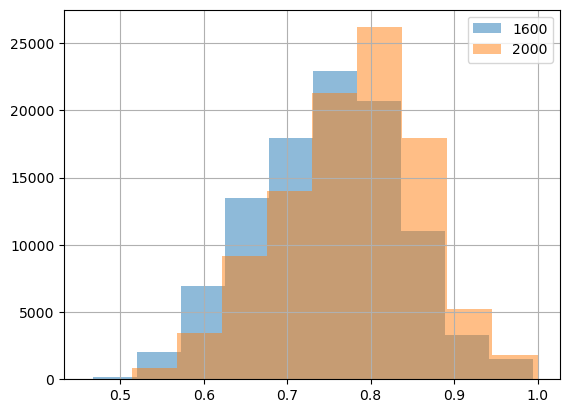

In [ ]:
imodel = 9
df_small = df_test.sample(100000).reset_index(drop=True)

istep1 = 1600
batch_size_pred = 5000
th = 0.9
df_test1, precision1, recall1 = get_df_with_preds(df_small, imodel, istep1, batch_size_pred)
df_test1 = df_test1.copy(deep=True)
istep2 = 2000
df_test2, precision2, recall2 = get_df_with_preds(df_small, imodel, istep2, batch_size_pred)
df_test1['pred_prob'].hist(alpha=0.5)
df_test2['pred_prob'].hist(alpha=0.5)
plt.legend([istep1,istep2])

0 5000
torch.Size([5000, 85655])
5000 10000
torch.Size([5000, 85655])
10000 15000
torch.Size([5000, 85655])
15000 20000
torch.Size([5000, 85655])
20000 25000
torch.Size([5000, 85655])
25000 30000
torch.Size([5000, 85655])
30000 35000
torch.Size([5000, 85655])
35000 40000
torch.Size([5000, 85655])
40000 45000
torch.Size([5000, 85655])
45000 50000
torch.Size([5000, 85655])
50000 55000
torch.Size([5000, 85655])
55000 60000
torch.Size([5000, 85655])
60000 65000
torch.Size([5000, 85655])
65000 70000
torch.Size([5000, 85655])
70000 75000
torch.Size([5000, 85655])
75000 80000
torch.Size([5000, 85655])
80000 85000
torch.Size([5000, 85655])
85000 90000
torch.Size([5000, 85655])
90000 95000
torch.Size([5000, 85655])
95000 100000
torch.Size([5000, 85655])
1400 0.7636317524727365 0.03011
0 5000
torch.Size([5000, 85655])
5000 10000
torch.Size([5000, 85655])
10000 15000
torch.Size([5000, 85655])
15000 20000
torch.Size([5000, 85655])
20000 25000
torch.Size([5000, 85655])
25000 30000
torch.Size([5000,

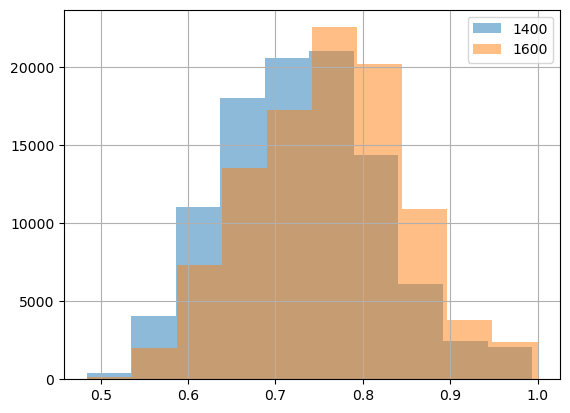

In [48]:
imodel = 9
df_small = df_test.sample(100000).reset_index(drop=True)

istep1 = 1400
batch_size_pred = 5000
th = 0.9
df_test1, precision1, recall1 = get_df_with_preds(df_small, imodel, istep1, batch_size_pred)
df_test1 = df_test1.copy(deep=True)
istep2 = 1600
df_test2, precision2, recall2 = get_df_with_preds(df_small, imodel, istep2, batch_size_pred)
df_test1['pred_prob'].hist(alpha=0.5)
df_test2['pred_prob'].hist(alpha=0.5)
plt.legend([istep1,istep2])

0 5000
torch.Size([5000, 88968])
5000 10000
torch.Size([5000, 88968])
10000 15000
torch.Size([5000, 88968])
15000 20000
torch.Size([5000, 88968])
20000 25000
torch.Size([5000, 88968])
25000 30000
torch.Size([5000, 88968])
30000 35000
torch.Size([5000, 88968])
35000 40000
torch.Size([5000, 88968])
40000 45000
torch.Size([5000, 88968])
45000 50000
torch.Size([5000, 88968])
50000 55000
torch.Size([5000, 88968])
55000 60000
torch.Size([5000, 88968])
60000 65000
torch.Size([5000, 88968])
65000 70000
torch.Size([5000, 88968])
70000 75000
torch.Size([5000, 88968])
75000 80000
torch.Size([5000, 88968])
80000 85000
torch.Size([5000, 88968])
85000 90000
torch.Size([5000, 88968])
90000 95000
torch.Size([5000, 88968])
95000 100000
torch.Size([5000, 88968])
100000 105000
torch.Size([5000, 88968])
105000 110000
torch.Size([5000, 88968])
110000 115000
torch.Size([5000, 88968])
115000 120000
torch.Size([5000, 88968])
120000 125000
torch.Size([5000, 88968])
125000 130000
torch.Size([5000, 88968])
13000

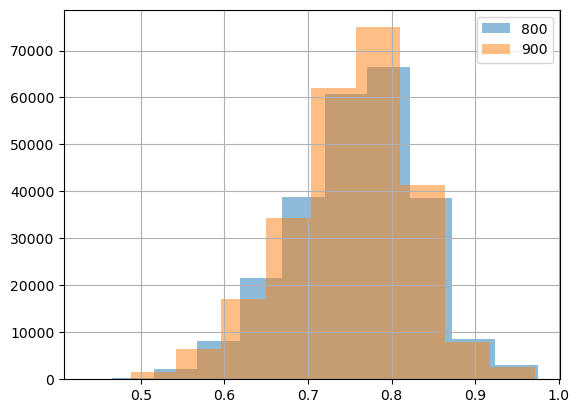

In [65]:
imodel = 7
istep1 = 800
th = 0.9
df_test1, precision1, recall1 = get_df_with_preds(df_test.reset_index(drop=True), imodel, istep1,batch_size_pred)
df_test1 = df_test1.copy(deep=True)
istep2 = 900
df_test2, precision2, recall2 = get_df_with_preds(df_test.reset_index(drop=True), imodel, istep2,batch_size_pred)
df_test1['pred_prob'].hist(alpha=0.5)
df_test2['pred_prob'].hist(alpha=0.5)
plt.legend([istep1,istep2])

0 84565
torch.Size([84565, 2001])
200 0.9263465900237201 0.632684916927807
0 84565
torch.Size([84565, 2001])
2000 0.9263465900237201 0.632684916927807
0 84565
torch.Size([84565, 2001])
2200 0.8617562838052816 0.12811446816058653


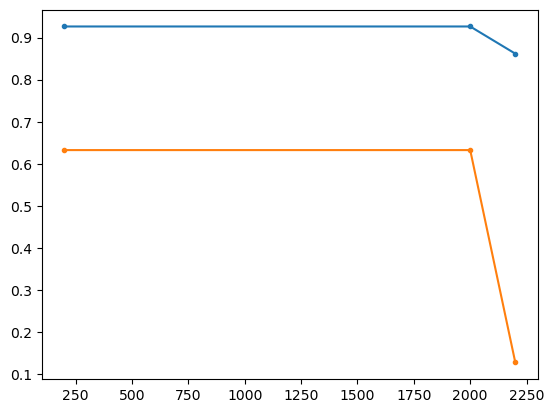

In [59]:
prec_vec, recall_vec = [], []
th = 0.9

istep in range(100, 300, 400):
# istep_range =  [200,2000,2200]
for istep in istep_range:
   
   model_name = f"/home/sagemaker-user/models/model{imodel}-{istep}"
   model = SentenceTransformer(model_name)
   df_test['pred_prob'] = 0.0
   df_test['pred_merchant']=""
   df_test = do_predictions(model, df_test,text_column, batch_size_pred,embeddings_merchants)
   precision, recall = get_prec_recall(df_test, th)
   print(istep, precision, recall)
   prec_vec.append(precision)
   recall_vec.append(recall)
plt.plot(istep_range,prec_vec,'.-')
plt.plot(istep_range,recall_vec,'.-')

In [44]:
#df_test1, precision1, recall1 = get_df_with_preds(df_test, imodel, 600, batch_size_pred)
#df_test2 has the lastest epoch

In [45]:
df_test2.head(2)

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label,pred_prob,pred_merchant
0,9808587425,SSA TREAS 310 DES:XXSOC SEC ID: C1 SSA INDN:AN...,SSA TREAS 310 DES:XXSOC SEC ID: C1 SSA INDN:AN...,SSA TREAS 310 DES:XXSOC SEC ID: C1 SSA INDN:AN...,Social Security Administration,0,Social Security Administration,1487.0,Social Security Administration,1,0.569095,0.640982,Pps
1,9824575271,Freddys 110- San Antonio Tx. Channel: in store...,Freddys 110- San Antonio Tx. Type: merchant. C...,Freddys 110- San Antonio Tx,Freddys Frozen Custard,0,Freddys Frozen Custard,-24.1,Freddys Frozen Custard,1,0.831068,0.825325,Freddys Mobile


### One epoch score distribution

In [51]:
df_test.shape[0]

130570

In [ ]:
#df_small = df_test.sample(100000).reset_index(drop=True)

0 5000
torch.Size([5000, 54311])
5000 10000
torch.Size([5000, 54311])
10000 15000
torch.Size([5000, 54311])
15000 20000
torch.Size([5000, 54311])
20000 25000
torch.Size([5000, 54311])
25000 30000
torch.Size([5000, 54311])
30000 35000
torch.Size([5000, 54311])
35000 40000
torch.Size([5000, 54311])
40000 45000
torch.Size([5000, 54311])
45000 50000
torch.Size([5000, 54311])
50000 55000
torch.Size([5000, 54311])
55000 60000
torch.Size([5000, 54311])
60000 65000
torch.Size([5000, 54311])
65000 70000
torch.Size([5000, 54311])
70000 75000
torch.Size([5000, 54311])
75000 80000
torch.Size([5000, 54311])
80000 85000
torch.Size([5000, 54311])
85000 90000
torch.Size([5000, 54311])
90000 95000
torch.Size([5000, 54311])
95000 100000
torch.Size([5000, 54311])
100000 105000
torch.Size([5000, 54311])
105000 110000
torch.Size([5000, 54311])
110000 115000
torch.Size([5000, 54311])
115000 120000
torch.Size([5000, 54311])
120000 125000
torch.Size([5000, 54311])
125000 130000
torch.Size([5000, 54311])
13000

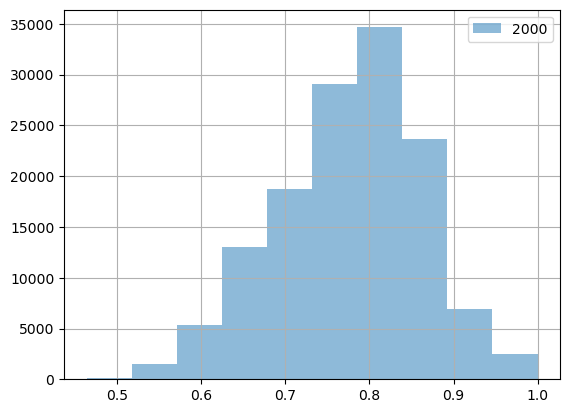

In [78]:
# one epoch

imodel = 9
istep1 = 2000
th = 0.75
df_test1, precision1, recall1 = get_df_with_preds(df_test.reset_index(drop=True), imodel, istep1,batch_size_pred)
df_test1['pred_prob'].hist(alpha=0.5)
plt.legend([istep1])

In [ ]:
#   original_merchant_name_combined is the real one ,
# merchant_name_cobined is the modified duplicate with coutnerprty 
# df_trans['original_merchant_name_combined'] = df_trans['merchant_name_combined']
# for duplicates , if counterparty_name != merchatn, then merchant_name_combined = counterparty_name
# merchant_name_combined : for duplicates, take

In [79]:
print(precision1, recall1)

0.7061960962324103 0.45922132357282014


# Lets look at the duplicates only

In [80]:
df_true_duplicates = df_test1[df_test1['is_duplicate']==1]
df_true_duplicates.reset_index(drop=True, inplace=True)
df_true_duplicates

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label,pred_prob,pred_merchant
0,9811397892,ONLINE TRANSFER TO ALDRICH S WAY2SAVE SAVINGS ...,ONLINE TRANSFER TO ALDRICH S WAY2SAVE SAVINGS ...,ONLINE TRANSFER TO ALDRICH S WAY2SAVE SAVINGS ...,Wells Fargo,1,Savings,-390.0,Wells Fargo,1,0.933549,0.627613,Savings
1,9839574018,"Cmsvend*Martin Vending,. Channel: in store. Am...","Cmsvend*Martin Vending,. Type: merchant. Chann...","Cmsvend*Martin Vending,",CMS Vending,1,CMS Vending Machines,-2.1,Savings,0,0.209168,0.772645,Cmf Vending
2,9924911740,Debit Card METAPAY*Joseph Weekusk pay.fb.com C...,Debit Card METAPAY*Joseph Weekusk pay.fb.com C...,Debit Card METAPAY*Joseph Weekusk pay.fb.com C...,Facebook Pay,1,Facebook,-3.0,Facebook Pay,1,0.884768,0.640250,Metapay
3,9884663341,FREDDY''S 43- E OAK ST CONWAY ARUS. Channel: i...,FREDDY''S 43- E OAK ST CONWAY ARUS. Type: merc...,FREDDY''S 43- E OAK ST CONWAY ARUS,Freddy''s Frozen Custard & Steakburgers,1,Freddys Frozen Custard,-12.2,Nayax Vending,0,0.064456,0.862706,Freddy's 00
4,9829544686,ONLINE TRANSFER FROM GREEN M WAY2SAVE SAVINGS ...,ONLINE TRANSFER FROM GREEN M WAY2SAVE SAVINGS ...,ONLINE TRANSFER FROM GREEN M WAY2SAVE SAVINGS ...,Wells Fargo,1,Savings,100.0,Wells Fargo,1,0.814877,0.596828,Savings Gas
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8087,9815054159,POS W/D STRAIGHTTALK*AIRTIME / 877-430- FLUS. ...,POS W/D STRAIGHTTALK*AIRTIME / 877-430- FLUS. ...,POS W/D STRAIGHTTALK*AIRTIME / 877-430- FLUS,Straight Talk,1,Straighttalk,-146.4,Afterpay,0,0.021343,0.809542,Straighttalk
8088,9815008109,Round-up Debit from Purchase DD DOORDASH CVS 8...,Round-up Debit from Purchase DD DOORDASH CVS 8...,Round-up Debit from Purchase DD DOORDASH CVS 8...,CVS,1,CVS Pharmacy,-0.9,CVS,1,0.795348,0.634952,CVS
8089,9822243247,ONLINE TRANSFER TO OSTHASATAYA W WAY2SAVE SAVI...,ONLINE TRANSFER TO OSTHASATAYA W WAY2SAVE SAVI...,ONLINE TRANSFER TO OSTHASATAYA W WAY2SAVE SAVI...,Wells Fargo,1,Savings,-10.0,Winn Dixie,0,0.096097,0.609906,To Wells Fargo Ifi
8090,9861831604,ONLINE TRANSFER TO KINNEY A WAY2SAVE SAVINGS R...,ONLINE TRANSFER TO KINNEY A WAY2SAVE SAVINGS R...,ONLINE TRANSFER TO KINNEY A WAY2SAVE SAVINGS R...,Wells Fargo,1,Savings,-100.0,Publix,0,0.305468,0.669924,To Wells Fargo Ifi


In [86]:
df_confident_duplicates = df_test1[(df_test1['pred_prob']>0.7) & (df_test['is_duplicate']==1)][['transaction_id','description_combined_processed','pred_merchant','true_merchant_name_combined','original_merchant_name_combined','pred_prob','is_duplicate']]
# ,'merchant_name_combined','true_label'
df_confident_duplicates

,transaction_id,description_combined_processed,pred_merchant,true_merchant_name_combined,original_merchant_name_combined,pred_prob,is_duplicate
31,9839574018,"Cmsvend*Martin Vending,",Cmf Vending,CMS Vending,CMS Vending Machines,0.772645,1
44,9884663341,FREDDY''S 43- E OAK ST CONWAY ARUS,Freddy's 00,Freddy''s Frozen Custard & Steakburgers,Freddys Frozen Custard,0.862706,1
66,9829579334,PAYPAL INST XFER PYPL PAYIN4 RYAN ROBERTSON,Paypal Pay in 4,Paypal Pay in 4,Paypal,0.768578,1
82,9821711712,Reversal: Credit Genie Connecti Conshohocken P...,Credit Genie,Credit Genie,Genie,0.785177,1
99,9819166054,QVC* *1 05-15 800-367- PA DEBIT CARD RECURRING...,Qvc,QVC,Qvc,0.853633,1
...,...,...,...,...,...,...,...
135358,9926783801,PURCHASE DRAFTKINGS MA,Draftkings,DraftKings,Draftkings,0.921313,1
135421,9830488761,CHECKCARD KLOVER PLUS IL MDJ,Klover Plus,Klover App,Klover,0.910204,1
135461,9822205334,RECURRING PAYMENT AUTHORIZED ON 05/15 DOORDASH...,Dashpa Www.doordash.,DoorDash,Doordash,0.858853,1
135496,9815054159,POS W/D STRAIGHTTALK*AIRTIME / 877-430- FLUS,Straighttalk,Straight Talk,Straighttalk,0.809542,1


Basically , we want to know what percentage got deduplicated 

- pred_merchant == original_merchant_name_combined

And what percentage got mapped to the original merchant 

- pred_merchant == true_merchant_name_combined


And how many times it got mapped to something else





In [100]:
#number of rows that got correctly mapped to the original merchant name
n_correct_duplicates_rows_detected_df = df_confident_duplicates[df_confident_duplicates['pred_merchant'] == df_confident_duplicates['original_merchant_name_combined']]

n_correct_duplicates_rows_detected = df_confident_duplicates[df_confident_duplicates['pred_merchant'] == df_confident_duplicates['original_merchant_name_combined']].shape[0]
n_correct_duplicates_rows_detected

2564

In [98]:
#number of rows that got correctly mapped to the duplicate name
n_correct_rows_mapped_df = df_confident_duplicates[df_confident_duplicates['pred_merchant'] == df_confident_duplicates['true_merchant_name_combined']]

n_correct_rows_mapped = df_confident_duplicates[df_confident_duplicates['pred_merchant'] == df_confident_duplicates['true_merchant_name_combined']].shape[0]
n_correct_rows_mapped

2029

In [99]:
#numebr of rows that were not correctly mapped to either the original or duplicate name
n_incorrect_rows_df = df_confident_duplicates[(df_confident_duplicates['pred_merchant'] != df_confident_duplicates['true_merchant_name_combined']) &\
    (df_confident_duplicates['pred_merchant'] != df_confident_duplicates['original_merchant_name_combined'])]


n_incorrect_rows= df_confident_duplicates[(df_confident_duplicates['pred_merchant'] != df_confident_duplicates['true_merchant_name_combined']) &\
    (df_confident_duplicates['pred_merchant'] != df_confident_duplicates['original_merchant_name_combined'])].shape[0]
n_incorrect_rows

1397

In [95]:
n_incorrect_rows_df= df_confident_duplicates[(df_confident_duplicates['pred_merchant'] != df_confident_duplicates['true_merchant_name_combined']) &\
    (df_confident_duplicates['pred_merchant'] != df_confident_duplicates['original_merchant_name_combined'])]

n_incorrect_rows_df[0:30]

,transaction_id,description_combined_processed,pred_merchant,true_merchant_name_combined,original_merchant_name_combined,pred_prob,is_duplicate
31,9839574018,"Cmsvend*Martin Vending,",Cmf Vending,CMS Vending,CMS Vending Machines,0.772645,1
44,9884663341,FREDDY''S 43- E OAK ST CONWAY ARUS,Freddy's 00,Freddy''s Frozen Custard & Steakburgers,Freddys Frozen Custard,0.862706,1
125,9820427673,Klarna*instacart Columbus OHUS,Klarna,Instacart,Point Of Sale Withdrawal,0.729986,1
126,9943149637,OPPFINANC PAYMENT - ELECTRONIC WITHDRAWAL,Oppfi Core,OppLoans,Opploans,0.743768,1
194,9810836833,PURCHASE CHUMBA GOLD COINS VALETTA,Chumba Gold Coin Valetta Wpgtid,Chumba Casino,Chumba Gold Coins,0.862404,1
213,9808702388,PHR*PremierMedical 05-14 251- AL DEBIT CARD PU...,Premier Health Phy,PHR,Phr,0.760544,1
251,9819245781,PURCHASE FANDUELSBKPRIMARY NJ,FanDuel,FanDuel Sportsbook,Fan Duel Sportsbook,0.891884,1
256,9810553335,PURCHASE ZIP* QUADPAY ANYWHE XXX-XX NY RECURRING,Ziply Fiber,Zip.co,Zip In,0.759749,1
392,9816845129,PURCHASE AUTHORIZED ON 05/14 MAVERIK #528 CHEY...,Maverik-we,Maverik,Maverik Convenience Store,0.751585,1
473,9807487453,Pos Debit- Klover Plus Chicago IL US,Klover Plus,Klover App,Klover,0.878778,1


### Find the pairs of merchants that are beind considered as non-duplicate, duplicate

In [103]:
n_correct_duplicate_pairs = n_correct_duplicates_rows_detected_df.drop_duplicates(subset=['pred_merchant','true_merchant_name_combined'])
n_correct_duplicate_pairs

,transaction_id,description_combined_processed,pred_merchant,true_merchant_name_combined,original_merchant_name_combined,pred_prob,is_duplicate
99,9819166054,QVC* *1 05-15 800-367- PA DEBIT CARD RECURRING...,Qvc,QVC,Qvc,0.853633,1
100,9838878959,Citgo K J Petrol,CITGO,Citgo,CITGO,0.870641,1
174,9829954985,PURCHASE AUTHORIZED ON 05/15 GOOGLE *Glu Games...,Glu Games Inc,Glu Games,Glu Games Inc,0.737047,1
183,9802624348,VONS # MAMMOTH LAKES CA,Vons Store,Vons,Vons Store,0.766709,1
243,9810798704,DOMINO''S PIZZA,Dominos Pizza,Domino''s,Dominos Pizza,0.905422,1
...,...,...,...,...,...,...,...
128935,9810424139,CHARMPASS - UNDERTEN OR 05/15,Charmpass Underten,Charmpass,Charmpass Underten,0.911274,1
130415,9835370025,PP*GOOGLE DOVLY COM,Google,Google Dovly Com,Google,0.703925,1
131026,9807812571,BJS FUEL # MIAMI FL,Bjs Fuel,BJ''s Wholesale Club Fuel,Bjs Fuel,0.838000,1
134607,9819792763,DBT CRD VOLA INC 929-295- NY CARD#,Vola,Vola Inc,Vola,0.740899,1


In [111]:
n_correct_nonduplicate_pairs = n_correct_rows_mapped_df.drop_duplicates(subset=['pred_merchant','original_merchant_name_combined'])
n_correct_nonduplicate_pairs

,transaction_id,description_combined_processed,pred_merchant,true_merchant_name_combined,original_merchant_name_combined,pred_prob,is_duplicate
66,9829579334,PAYPAL INST XFER PYPL PAYIN4 RYAN ROBERTSON,Paypal Pay in 4,Paypal Pay in 4,Paypal,0.768578,1
82,9821711712,Reversal: Credit Genie Connecti Conshohocken P...,Credit Genie,Credit Genie,Genie,0.785177,1
188,9811141187,PURCHASE AUTHORIZED ON 05/15 KLOVER APP BOOST ...,Klover App,Klover App,Klover,0.741210,1
385,9951698307,POS Debit - Visa Check Card - APPLE CASH SENT ...,Apple Cash,Apple Cash,Apple,0.775243,1
604,9962427090,CarMax Auto,CarMax,CarMax,Car Max,0.922730,1
...,...,...,...,...,...,...,...
127101,9822317070,Point of Sale Debit L340 DATE 05-15 QVC* * -367-,QVC,QVC,Qvc,0.800955,1
128978,9882650340,VISA DDA PUR AP METRO BY T MOBILE MOBI 888 863...,Metro By T Mobile Mobi,Metro By T Mobile Mobi,Metro By T Mobile,0.840607,1
131567,9836283764,Pos Debit- Marathon Food Ma Tucker US,Marathon Food Ma,Marathon Food Ma,Marathon Food,0.897185,1
131875,9807523492,FANDUELSBKPRIMARY JERSEY CI TY NJFANDUELSB KP,FanDuel Sportsbook,FanDuel Sportsbook,Fan Duel Sportsbook,0.854863,1


In [108]:
n_incorrect_duplicate_pairs = n_incorrect_rows_df.drop_duplicates(subset=['pred_merchant','original_merchant_name_combined'])
n_incorrect_duplicate_pairs[0:30]

,transaction_id,description_combined_processed,pred_merchant,true_merchant_name_combined,original_merchant_name_combined,pred_prob,is_duplicate
31,9839574018,"Cmsvend*Martin Vending,",Cmf Vending,CMS Vending,CMS Vending Machines,0.772645,1
44,9884663341,FREDDY''S 43- E OAK ST CONWAY ARUS,Freddy's 00,Freddy''s Frozen Custard & Steakburgers,Freddys Frozen Custard,0.862706,1
125,9820427673,Klarna*instacart Columbus OHUS,Klarna,Instacart,Point Of Sale Withdrawal,0.729986,1
126,9943149637,OPPFINANC PAYMENT - ELECTRONIC WITHDRAWAL,Oppfi Core,OppLoans,Opploans,0.743768,1
194,9810836833,PURCHASE CHUMBA GOLD COINS VALETTA,Chumba Gold Coin Valetta Wpgtid,Chumba Casino,Chumba Gold Coins,0.862404,1
213,9808702388,PHR*PremierMedical 05-14 251- AL DEBIT CARD PU...,Premier Health Phy,PHR,Phr,0.760544,1
251,9819245781,PURCHASE FANDUELSBKPRIMARY NJ,FanDuel,FanDuel Sportsbook,Fan Duel Sportsbook,0.891884,1
256,9810553335,PURCHASE ZIP* QUADPAY ANYWHE XXX-XX NY RECURRING,Ziply Fiber,Zip.co,Zip In,0.759749,1
392,9816845129,PURCHASE AUTHORIZED ON 05/14 MAVERIK #528 CHEY...,Maverik-we,Maverik,Maverik Convenience Store,0.751585,1
473,9807487453,Pos Debit- Klover Plus Chicago IL US,Klover Plus,Klover App,Klover,0.878778,1


In [109]:
n_true_duplicates = df_true_duplicates.drop_duplicates(subset=['pred_merchant','original_merchant_name_combined'])
n_true_duplicates

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label,pred_prob,pred_merchant
0,9811397892,ONLINE TRANSFER TO ALDRICH S WAY2SAVE SAVINGS ...,ONLINE TRANSFER TO ALDRICH S WAY2SAVE SAVINGS ...,ONLINE TRANSFER TO ALDRICH S WAY2SAVE SAVINGS ...,Wells Fargo,1,Savings,-390.0,Wells Fargo,1,0.933549,0.627613,Savings
1,9839574018,"Cmsvend*Martin Vending,. Channel: in store. Am...","Cmsvend*Martin Vending,. Type: merchant. Chann...","Cmsvend*Martin Vending,",CMS Vending,1,CMS Vending Machines,-2.1,Savings,0,0.209168,0.772645,Cmf Vending
2,9924911740,Debit Card METAPAY*Joseph Weekusk pay.fb.com C...,Debit Card METAPAY*Joseph Weekusk pay.fb.com C...,Debit Card METAPAY*Joseph Weekusk pay.fb.com C...,Facebook Pay,1,Facebook,-3.0,Facebook Pay,1,0.884768,0.640250,Metapay
3,9884663341,FREDDY''S 43- E OAK ST CONWAY ARUS. Channel: i...,FREDDY''S 43- E OAK ST CONWAY ARUS. Type: merc...,FREDDY''S 43- E OAK ST CONWAY ARUS,Freddy''s Frozen Custard & Steakburgers,1,Freddys Frozen Custard,-12.2,Nayax Vending,0,0.064456,0.862706,Freddy's 00
4,9829544686,ONLINE TRANSFER FROM GREEN M WAY2SAVE SAVINGS ...,ONLINE TRANSFER FROM GREEN M WAY2SAVE SAVINGS ...,ONLINE TRANSFER FROM GREEN M WAY2SAVE SAVINGS ...,Wells Fargo,1,Savings,100.0,Wells Fargo,1,0.814877,0.596828,Savings Gas
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8010,9857571075,WITHDRAWAL Debit Card BETMGM ONLINE NJ Date 05...,WITHDRAWAL Debit Card BETMGM ONLINE NJ Date 05...,WITHDRAWAL Debit Card BETMGM ONLINE NJ Date 05...,BetMGM,1,BetMGM.com,-30.0,Hulu,0,0.203959,0.793196,Bet365.in
8027,9823027972,DD *DOORDASH VONS WWW.DOORDASH. CA 05/16. Chan...,DD *DOORDASH VONS WWW.DOORDASH. CA 05/16. Type...,DD *DOORDASH VONS WWW.DOORDASH. CA 05/16,Vons,1,Vons Store,-40.6,North Shore Bk,0,0.179907,0.665882,DoorDash
8032,9841926925,Deposit Debit Card CASH APP*TYRESE*CASH OUT Sa...,Deposit Debit Card CASH APP*TYRESE*CASH OUT Sa...,Deposit Debit Card CASH APP*TYRESE*CASH OUT Sa...,Cash App,1,Cash App,47.2,Cash App,1,0.725642,0.543296,Cash
8041,9819792763,DBT CRD VOLA INC 929-295- NY CARD# . Channel: ...,DBT CRD VOLA INC 929-295- NY CARD# . Type: mer...,DBT CRD VOLA INC 929-295- NY CARD#,Vola Inc,1,Vola,-20.0,Vola Inc,1,0.850330,0.740899,Vola


In [115]:
df_true_duplicate_pairs = df_true_duplicates.drop_duplicates(subset=['pred_merchant','original_merchant_name_combined'])
df_true_duplicate_pairs

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label,pred_prob,pred_merchant
0,9811397892,ONLINE TRANSFER TO ALDRICH S WAY2SAVE SAVINGS ...,ONLINE TRANSFER TO ALDRICH S WAY2SAVE SAVINGS ...,ONLINE TRANSFER TO ALDRICH S WAY2SAVE SAVINGS ...,Wells Fargo,1,Savings,-390.0,Wells Fargo,1,0.933549,0.627613,Savings
1,9839574018,"Cmsvend*Martin Vending,. Channel: in store. Am...","Cmsvend*Martin Vending,. Type: merchant. Chann...","Cmsvend*Martin Vending,",CMS Vending,1,CMS Vending Machines,-2.1,Savings,0,0.209168,0.772645,Cmf Vending
2,9924911740,Debit Card METAPAY*Joseph Weekusk pay.fb.com C...,Debit Card METAPAY*Joseph Weekusk pay.fb.com C...,Debit Card METAPAY*Joseph Weekusk pay.fb.com C...,Facebook Pay,1,Facebook,-3.0,Facebook Pay,1,0.884768,0.640250,Metapay
3,9884663341,FREDDY''S 43- E OAK ST CONWAY ARUS. Channel: i...,FREDDY''S 43- E OAK ST CONWAY ARUS. Type: merc...,FREDDY''S 43- E OAK ST CONWAY ARUS,Freddy''s Frozen Custard & Steakburgers,1,Freddys Frozen Custard,-12.2,Nayax Vending,0,0.064456,0.862706,Freddy's 00
4,9829544686,ONLINE TRANSFER FROM GREEN M WAY2SAVE SAVINGS ...,ONLINE TRANSFER FROM GREEN M WAY2SAVE SAVINGS ...,ONLINE TRANSFER FROM GREEN M WAY2SAVE SAVINGS ...,Wells Fargo,1,Savings,100.0,Wells Fargo,1,0.814877,0.596828,Savings Gas
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8010,9857571075,WITHDRAWAL Debit Card BETMGM ONLINE NJ Date 05...,WITHDRAWAL Debit Card BETMGM ONLINE NJ Date 05...,WITHDRAWAL Debit Card BETMGM ONLINE NJ Date 05...,BetMGM,1,BetMGM.com,-30.0,Hulu,0,0.203959,0.793196,Bet365.in
8027,9823027972,DD *DOORDASH VONS WWW.DOORDASH. CA 05/16. Chan...,DD *DOORDASH VONS WWW.DOORDASH. CA 05/16. Type...,DD *DOORDASH VONS WWW.DOORDASH. CA 05/16,Vons,1,Vons Store,-40.6,North Shore Bk,0,0.179907,0.665882,DoorDash
8032,9841926925,Deposit Debit Card CASH APP*TYRESE*CASH OUT Sa...,Deposit Debit Card CASH APP*TYRESE*CASH OUT Sa...,Deposit Debit Card CASH APP*TYRESE*CASH OUT Sa...,Cash App,1,Cash App,47.2,Cash App,1,0.725642,0.543296,Cash
8041,9819792763,DBT CRD VOLA INC 929-295- NY CARD# . Channel: ...,DBT CRD VOLA INC 929-295- NY CARD# . Type: mer...,DBT CRD VOLA INC 929-295- NY CARD#,Vola Inc,1,Vola,-20.0,Vola Inc,1,0.850330,0.740899,Vola


In [118]:
#precison and recall of duplicate identification


# precision = tp /tp + fp

precision_detece_duplicates = n_correct_duplicate_pairs.shape[0]/(n_correct_duplicate_pairs.shape[0] + n_incorrect_duplicate_pairs.shape[0])
print(f"Precision of duplicate detection precision {precision_detece_duplicates}")


precision = (n_correct_duplicate_pairs.shape[0] + n_correct_nonduplicate_pairs.shape[0])/(n_correct_duplicate_pairs.shape[0] +n_correct_nonduplicate_pairs.shape[0]+ n_incorrect_duplicate_pairs.shape[0])
print(f"Precison of merchant detection {precision}")

# recall = tp/tp + fn

recall = n_correct_duplicate_pairs.shape[0]/df_true_duplicate_pairs.shape[0]
print(f"Recall of duplicate detection {recall}")



Precision of duplicate detection precision 0.4740532959326788
Precison of merchant detection 0.6048472075869337
Recall of duplicate detection 0.25742574257425743


In [ ]:
df_confident_duplicates

# labels of merchant Names 

 - original_merchant_name_combined: the ground truth for the merchant name
 
 - If the row is not a duplicate, then original_merchant_name_combined = true_merchant_name_combined

 - If the row is a duplicate, then original_merchant_name_combined != true_merchant_name_combined, because the true_merchant_name is an artifical creation of a duplicate using coutnerparies type merchant. 


The column merchant name combined was created using the coutnerparties merchant name, when it was different to the Cleo name. So the names are different, we would hope that the we can identity that the combined name

In [49]:
df_confident_duplicates[df_confident_duplicates['pred_merchant'] !=  df_confident_duplicates['merchant_name_combined']]

,transaction_id,description_combined_processed,pred_merchant,original_merchant_name_combined,pred_prob,is_duplicate,merchant_name_combined
29,9804645681,"7-ELEVEN , + , TX",7-Eleven,7 Eleven,0.889205,1,Albert
110,9811478214,Credit/Debit Card Deposit: Deposit Debit Card ...,Dave Inc,Dave Inc,0.775294,1,Welcome
134,9829638427,PURCHASE AUTHORIZED ON 05/15 T J MAXX 4TH AV R...,T J Maxx,T.J.Maxx,0.742390,1,POS Deposit
223,9815154752,PURCHASE AUTHORIZED ON 05/15 HARRIS TEETER #0 ...,Harris Teeter,Harris Teeter,0.728557,1,Dave Inc
245,9866372551,SHIPLEY DO-NUTS - FC52 281- TX 05/14,Shipley Do-nuts,Shipley Donuts,0.811022,1,Apple
...,...,...,...,...,...,...,...
248326,9819322123,Point of Sale Debit L340 TIME 05:44 PM DATE 05...,Ulta,Ulta,0.754578,1,Ulta Beauty
248489,9826746296,PURCHASE AUTHORIZED ON 05/14 IN-N-OUT EL CAJON...,In-n-out Redding,In N Out Burger,0.709448,1,In-N-Out Burger
248493,9808076466,RACETRAC454 PORT ALLEN LA PS ...,Racetrac,Racetrac,0.801910,1,RaceTrac
248539,9951538871,Withdrawal POS # H-E-B #798 WOODLAND HILLS DR ...,H-E-B,Heb,0.719373,1,Cash Withdrawal


### Common confusions

In [50]:
df_confident_duplicates['pred_vs_true'] = df_confident_duplicates['pred_merchant']+ ' ::  ' + df_confident_duplicates['original_merchant_name_combined']

In [51]:
df_potential_duplicates = df_confident_duplicates[df_confident_duplicates['pred_merchant'] != df_confident_duplicates['original_merchant_name_combined']]['pred_vs_true'].value_counts().to_frame()
df_potential_duplicates.reset_index(drop=False, inplace=True)
df_potential_duplicates[0:30]

,pred_vs_true,count
0,7-Eleven :: 7 Eleven,547
1,AfterPay :: Afterpay,357
2,FanDuel :: Fan Duel Sportsbook,313
3,Klover App :: Klover,247
4,Dunkin&#39 :: Dunkin'' Donuts,234
5,Ziply Fiber :: Zip In,203
6,DraftKings :: Draftkings,198
7,3 C Market 5640 :: 365 Markets,163
8,Dave Membership :: Dave Inc,155
9,Klover Plus :: Klover,131


In [52]:
df_potential_duplicates[df_potential_duplicates['count']>=3]

,pred_vs_true,count
0,7-Eleven :: 7 Eleven,547
1,AfterPay :: Afterpay,357
2,FanDuel :: Fan Duel Sportsbook,313
3,Klover App :: Klover,247
4,Dunkin&#39 :: Dunkin'' Donuts,234
...,...,...
219,Cvsextracare X6 :: CVS Pharmacy,3
220,Klarna :: SHEIN,3
221,SoFi :: So Fi,3
222,Crunchyroll Com :: Crunchyroll Member,3


In [53]:
# with a threshold of 0.8
# Looking at duplicates and a minimum of 3 transactions , 
true_positives_duplicates = df_potential_duplicates[df_potential_duplicates['count']>=2].shape[0]
true_positives_duplicates

284

In [54]:
#false negatives
false_negatives_duplicates = df_test1[(df_test1['is_duplicate']==1) & (df_test1['pred_prob']<0.7) ].shape[0]

In [59]:
df_test1.head()

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label,pred_prob,pred_merchant
0,9817740680,XX DDA POS PURCH 05/16 06:54 MURPHY ATWALM BLA...,XX DDA POS PURCH 05/16 06:54 MURPHY ATWALM BLA...,XX DDA POS PURCH 05/16 06:54 MURPHY ATWALM BLA...,Murphy Express,0,Murphy Express,-50.0,Amazon Prime,0,0.069947,0.732704,Murphy6778 Atwal Baton Rouge
1,9809148759,SIGNATURE DEBIT CIRCLE K # MACCLENNY FL. Chann...,SIGNATURE DEBIT CIRCLE K # MACCLENNY FL. Type:...,SIGNATURE DEBIT CIRCLE K # MACCLENNY FL,Circle K,0,Circle K,-0.7,Online Banking Transfer,0,0.056713,0.816716,Circle K
2,9809106548,SAMS CLUB # 05-13 CAPE CORALFL DEBIT CARD RETU...,SAMS CLUB # 05-13 CAPE CORALFL DEBIT CARD RETU...,SAMS CLUB # 05-13 CAPE CORALFL DEBIT CARD RETURN,Sam''s Club,0,Sam''s Club,38.3,Sam''s Club,1,0.907195,0.719998,Sam''s Club
3,9836473294,POS Withdrawal - AVIAGAMES INC WYANDOTTE ST # ...,POS Withdrawal - AVIAGAMES INC WYANDOTTE ST # ...,POS Withdrawal - AVIAGAMES INC WYANDOTTE ST # ...,Avia Games,0,Avia Games,-5.0,Avia Games,1,0.840230,0.786127,Aviagames Inc
4,9906936396,VISA DDA PUR AP GRID PYMNT QPRPKDPP39Y18 GETGR...,VISA DDA PUR AP GRID PYMNT QPRPKDPP39Y18 GETGR...,VISA DDA PUR AP GRID PYMNT QPRPKDPP39Y18 GETGR...,Grid,0,Grid,-30.6,7 Eleven,0,0.109405,0.709312,Grid App


In [62]:
 not_confident_duplicates = df_test1[(df_test1['is_duplicate']==1) & (df_test1['pred_prob']<0.7) & (df_test1['pred_merchant']!= df_test['original_merchant_name_combined'])][['pred_prob','pred_merchant','original_merchant_name_combined']]
 not_confident_duplicates

,pred_prob,pred_merchant,original_merchant_name_combined
324,0.665494,AfterPay,Afterpay
556,0.697389,Savings Gas,Savings
630,0.686148,Savings Gas,Savings
659,0.615056,AfterPay,Afterpay
686,0.651179,Wells Fargo,Wells Fargo Card
...,...,...,...
248528,0.665673,Supplement Giant,Giant Food Inc
248535,0.612956,Savings Gas,Savings
248549,0.653048,Cash's,Cash App
248594,0.591225,Paymt,Pay Activ


In [63]:
not_confident_duplicates['pred_vs_true'] = not_confident_duplicates['pred_merchant']+ ' ::  ' + not_confident_duplicates['original_merchant_name_combined']

In [64]:
not_confident_duplicates['pred_vs_true'].value_counts()

pred_vs_true
Savings Gas ::  Savings                          399
Cash App. ::  Cash App                           131
Wf Credit Card ::  Cash Withdrawal                97
PayPal ::  Paypal                                 40
AfterPay ::  Afterpay                             38
                                                ... 
Jpmc Ncc Cafe ::  Jpmc Cafe Mashgin Plano          1
Citi Card ::  Cash Withdrawal                      1
Capital One Europe ::  Capital One Mobile Pmt      1
Cashnet ::  Cashnetusa                             1
Paymt ::  Pay Activ                                1
Name: count, Length: 648, dtype: int64

In [55]:
false_negatives_duplicates

4085

In [163]:
false_negatives_duplicates_data = df_test1[(df_test1['is_duplicate']==1) & (df_test1['pred_prob']<0.75) ]
false_negatives_duplicates_data

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label,pred_prob,pred_merchant
71,9825560235,ONLINE TRANSFER FROM MCNAIR A WAY2SAVE SAVINGS...,ONLINE TRANSFER FROM MCNAIR A WAY2SAVE SAVINGS...,ONLINE TRANSFER FROM MCNAIR A WAY2SAVE SAVINGS...,Wells Fargo,1,Savings,150.0,Sheetz,0,0.139824,0.709434,Savings Gas
96,9816972326,ONLINE TRANSFER FROM YOUNG S WAY2SAVE SAVINGS ...,ONLINE TRANSFER FROM YOUNG S WAY2SAVE SAVINGS ...,ONLINE TRANSFER FROM YOUNG S WAY2SAVE SAVINGS ...,Wells Fargo,1,Savings,676.6,Wells Fargo,1,0.901449,0.682301,Savings
164,9843025034,Withdrawal Debit Card SIGNATURE BASED Prime Vi...,Withdrawal Debit Card SIGNATURE BASED Prime Vi...,Withdrawal Debit Card SIGNATURE BASED Prime Vi...,Amazon Prime Video,1,Amazon Prime,-5.0,Amazon Prime Video,1,0.885940,0.687408,Amazon Prime Video
213,9810690095,NON-WF ATM WITHDRAWAL AUTHORIZED ON 05/15 710 ...,NON-WF ATM WITHDRAWAL AUTHORIZED ON 05/15 710 ...,NON-WF ATM WITHDRAWAL AUTHORIZED ON 05/15 710 ...,Wells Fargo,1,Cash Withdrawal,-23.4,Wells Fargo,1,0.994184,0.633307,Wf Credit Card
259,9819471143,ONLINE TRANSFER FROM HICKS S WAY2SAVE SAVINGS ...,ONLINE TRANSFER FROM HICKS S WAY2SAVE SAVINGS ...,ONLINE TRANSFER FROM HICKS S WAY2SAVE SAVINGS ...,Wells Fargo,1,Savings,10.0,In N Out Burger,0,0.090042,0.678695,Savings
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249087,9823298075,NON-CHASE ATM WITHDRAW 05/ BROAD. Channel: Non...,NON-CHASE ATM WITHDRAW 05/ BROAD. Type: financ...,NON-CHASE ATM WITHDRAW 05/ BROAD,Chase Bank,1,Cash Withdrawal,-22.0,Chase Bank,1,0.766347,0.749209,Chase Bank
249171,9842720171,POS Debit - Visa Check Card - KLOVER APP BOOST...,POS Debit - Visa Check Card - KLOVER APP BOOST...,POS Debit - Visa Check Card - KLOVER APP BOOST...,Klover App,1,Klover,-82.4,Steam,0,0.282852,0.746376,Klover App
249193,9842856838,POS Adjustment - APPLE CASH INST XF CUPERTINO ...,POS Adjustment - APPLE CASH INST XF CUPERTINO ...,POS Adjustment - APPLE CASH INST XF CUPERTINO ...,Apple Cash,1,Adjustment,98.5,Snapmath,0,0.035135,0.663559,Apple Cash
249324,9819222557,CVS/PHARM - -- South B Alv - . Channel: in sto...,CVS/PHARM - -- South B Alv - . Type: merchant....,CVS/PHARM - -- South B Alv -,CVS,1,CVS Pharmacy,-30.1,CVS,1,0.829987,0.716642,CVS Pharmacy


'Cash App'

In [129]:
df_potential_duplicates[-30:]

,pred_vs_true,count
797,Cash App Aaliyah :: Cash App Transfer,1
798,Cash App Dee :: Cash App Dee Hicks,1
799,Cash App Mel :: Cash App Mellow,1
800,Cash App K D :: Cash App Kobie,1
801,Cash App Cjay :: Cash App Pjay,1
802,Cash App Madison :: Cash App Transfer,1
803,Cash App Travis Tho :: Cash App Arturo,1
804,Cash App Kenna :: Cash App Kennia,1
805,Cash App Fab :: Cash App Fam,1
806,Cash App Anthony S :: Cash App Anthony R,1


In [ ]:
df_potential_duplicates

In [114]:
df_confident_duplicates['pred_vs_true'].value_counts()

pred_vs_true
Dave Inc Dave Inc                          821
7-Eleven 7 Eleven                          470
Afterpay Afterpay                          198
Dunkin'' Dunkin'' Donuts                   190
CVS Pharmacy CVS Pharmacy                  174
                                          ... 
Cash App Ke Cash App Keosha                  1
Cash App Des Cash App Desean                 1
Oportun Rainy Day Oportun Rainy Day          1
Cash App Ashley Burton                       1
Cash App Carla Point Of Sale Withdrawal      1
Name: count, Length: 1415, dtype: Int64

In [ ]:
df_confident_duplicates[df_confident_duplicates['pred_merchant'] !=  df_confident_duplicates['merchant_name_combined']]

In [52]:
get_prec_recall(df_test1, th=0.8)

(0.6416177147343061, 0.202415112386418)

### How many of the duplicates did it find?

In [59]:
all_duplicates = df_test2[df_test2['is_duplicate'] == 1][:]
all_duplicates[all_duplicates['pred_merchant']!= all_duplicates['true_merchant_name_combined']]

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label,pred_prob,pred_merchant
8,9809396647,PURCHASE ZIP* QUADPAY ANYWHE XXX-XX NY RECURRI...,PURCHASE ZIP* QUADPAY ANYWHE XXX-XX NY RECURRI...,PURCHASE ZIP* QUADPAY ANYWHE XXX-XX NY RECURRING,Zip.co,1,Zip In,-14.2,Zip.co,1,0.680956,0.737677,Ziply Fiber
45,9816972326,ONLINE TRANSFER FROM YOUNG S WAY2SAVE SAVINGS ...,ONLINE TRANSFER FROM YOUNG S WAY2SAVE SAVINGS ...,ONLINE TRANSFER FROM YOUNG S WAY2SAVE SAVINGS ...,Wells Fargo,1,Savings,676.6,Wells Fargo,1,0.901449,0.667018,Savings
47,9808523732,PROGRESSIVELEASE PMTS . Channel: None. Amount:...,PROGRESSIVELEASE PMTS . Type: financial_instit...,PROGRESSIVELEASE PMTS,Progressive Leasing,1,Progressive Lease,-48.3,Progressive Leasing,1,0.793004,0.761640,Progressive Lease
59,9811980660,PURCHASE FORTIVA MC. Channel: None. Amount: -25.0,PURCHASE FORTIVA MC. Type: financial_instituti...,PURCHASE FORTIVA MC,Fortiva,1,Fortiva Mc,-25.0,Fortiva,1,0.895653,0.880212,Fortiva Mc
62,9812485334,CHECKCARD CHIPOTLE GRAND PRAIRIETX . Channel: ...,CHECKCARD CHIPOTLE GRAND PRAIRIETX . Type: mer...,CHECKCARD CHIPOTLE GRAND PRAIRIETX,Chipotle Mexican Grill,1,Chipotle,-55.4,Chipotle Mexican Grill,1,0.876486,0.829878,Chipotle
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116920,9808807006,"DB DEBIT - 5-15- , FANDUELSBKPRIMARY NJ,AUTH# ...","DB DEBIT - 5-15- , FANDUELSBKPRIMARY NJ,AUTH# ...","DB DEBIT - 5-15- , FANDUELSBKPRIMARY NJ,AUTH# ...",FanDuel Sportsbook,1,Fan Duel Sportsbook,-5.0,FanDuel Sportsbook,1,0.932282,0.770255,FanDuel
116945,9869711828,ONLINE TRANSFER TO MICHEL R WAY2SAVE SAVINGS R...,ONLINE TRANSFER TO MICHEL R WAY2SAVE SAVINGS R...,ONLINE TRANSFER TO MICHEL R WAY2SAVE SAVINGS R...,Wells Fargo,1,Savings,-80.0,Wells Fargo,1,0.897926,0.622277,Savings To Checking
117027,9841744734,CASH APP*CARLA*ADD San Francisco CAUS. Channe...,CASH APP*CARLA*ADD San Francisco CAUS. Type: ...,CASH APP*CARLA*ADD San Francisco CAUS,Cash App,1,Point Of Sale Withdrawal,-25.0,Cash App,1,0.863087,0.805727,Cash App Carla
117066,9819222557,CVS/PHARM - -- South B Alv - . Channel: in sto...,CVS/PHARM - -- South B Alv - . Type: merchant....,CVS/PHARM - -- South B Alv -,CVS,1,CVS Pharmacy,-30.1,CVS,1,0.829987,0.717721,4cvs Pharm


In [55]:
#Let's look at the duplicates quality with the first epoch
some_cols = ['transaction_id','pred_prob','pred_merchant','true_merchant_name_combined','original_merchant_name_combined','description_combined_processed','is_duplicate']
df_potential_dups = df_test2[(df_test2['pred_prob']>0.8) & (df_test2['true_merchant_name_combined'] != df_test2['pred_merchant'])][some_cols]
df_potential_dups.reset_index(drop=True, inplace=True)
df_potential_dups

,transaction_id,pred_prob,pred_merchant,true_merchant_name_combined,original_merchant_name_combined,description_combined_processed,is_duplicate
0,9824575271,0.825325,Freddys Mobile,Freddys Frozen Custard,Freddys Frozen Custard,Freddys 110- San Antonio Tx,0
1,9831911149,0.843733,Tp 7 Brew Sb,Brew Sb,Brew Sb,Withdrawal TIL*TP 7 BREW SB267 ( -05-17),0
2,9819513927,0.862629,7-Eleven,7 Eleven,7 Eleven,7-ELEVEN 05/15 # PURCHASE 7-ELEVEN Redondo Bea...,0
3,9818899162,0.838592,Uber Eat,Uber Eats,Uber Eats,UBER EATS CA Mobile Purchase Sign Based 05/13 ...,0
4,9809746890,0.836114,FanDuel,Fan Duel Sportsbook,Fan Duel Sportsbook,PURCHASE AUTHORIZED ON 05/14 FANDUELSBKPRIMARY...,0
...,...,...,...,...,...,...,...
13234,9800634706,0.849260,Dunkin'',Dunkin'' Donuts,Dunkin'' Donuts,DUNKIN # Q35,0
13235,9816584906,0.815012,Target St,Target,Target,Pos Debit- Target Winter Garden FL,0
13236,9801827245,0.803302,Zip Gift Cards,Zip In,Zip In,ZIP PAYMENT D218EA,0
13237,9827676688,0.875824,Affirmcard,Affirm,Affirm,AFFIRM INC AFFIRM PAY WEB ID:,0


In [56]:
df_test1[ (df_test1['is_duplicate']==1) & (df_test1['pred_prob']>0.8)][some_cols]

,transaction_id,pred_prob,pred_merchant,true_merchant_name_combined,original_merchant_name_combined,description_combined_processed,is_duplicate
651,9819624864,0.853664,Greenline Loans I Db,Greenline Loans I Db,Greenline Loans,Greenline Loans/I DB,1
1269,10022989596,0.840014,Mbi Huck''s Food & Fuel,Huck''s Food & Fuel Store,Huck''s Food & Fuel,HUCK''S FOOD & FUEL STO Sturgis K,1
1793,9808270487,0.822527,Esg Mobig.Co/Helppayca,Scopely,Scopely Inc,GOOGLE *Scopely Inc g.co/helppay#CA,1
4849,9805530838,0.891283,Five Star Food Service,Five Star Food Service,Five Star Food,Five Star Food Services,1
4913,9889556734,0.883503,Fresh Donuts,AVON,Avon,Avon Fresh Donuts,1
...,...,...,...,...,...,...,...
276821,9800122549,0.835972,Parkwhiz Inc,ParkWhiz,Parkwhiz Inc,"ParkWhiz, Inc.",1
277096,9837916194,0.876182,AviaGames,AviaGames,Avia Games,Aviagames,1
277698,9838521876,0.925392,Total Wine And More,Total Wine & More,Total Wine And More,Total Wine And More,1
277872,9830287878,0.863770,Credit One Bank,Credit One Bank,Credit One Bank Payment,Credit one bank,1


In [57]:
df_test1['merchant_pairs'] = df_test1.apply(lambda x: x['true_merchant_name_combined']+ ' , ' + x['pred_merchant'], axis=1)

In [58]:
#df_potential_dups['merchant_pairs'] = df_potential_dups['true_merchant_name_combined']
df_potential_dups['merchant_pairs'] = df_potential_dups.apply(lambda x: x['true_merchant_name_combined']+ ' , ' + x['pred_merchant'], axis=1)

In [59]:
df_duplicate_cand_counts = df_potential_dups[['merchant_pairs']].value_counts().to_frame()
df_duplicate_cand_counts.reset_index(drop=False, inplace=True)
df_duplicate_cand_counts[0:30]

,merchant_pairs,count
0,"60 , Direct Debit Payment",98
1,"Walmart , Wal-martsuper Center",70
2,"7 Eleven , 7-Eleven",58
3,"Loan Payment , Onl To Loan",53
4,"Netflix , Netflix.co",48
5,"Racetrac , RaceTrac",41
6,"Hy-Vee , Hy Vee F&f",39
7,"Dominos Pizza , Domino''s",36
8,"Brigit , Brigit-com Protection",33
9,"Paypal , Paypal Pay in 4",27


In [133]:
df_data_processed[df_data_processed['transaction_id']==9790597722]

,transaction_id,corrected_made_on,amount,description_combined,merchant_name_combined,description_combined_processed,sentence,sentence2,payment_channel
1647418,9790597722,2024-05-14,-20.0,Withdrawal PFCU Check Card / Cleo Repayments W...,Cleo Re,Withdrawal PFCU Check Card / Cleo Repayments W...,Withdrawal PFCU Check Card / Cleo Repayments W...,Withdrawal PFCU Check Card / Cleo Repayments W...,in store
3428017,9790597722,2024-05-14,-20.0,Withdrawal PFCU Check Card / Cleo Repayments W...,Cleo Re,Withdrawal PFCU Check Card / Cleo Repayments W...,Withdrawal PFCU Check Card / Cleo Repayments W...,Withdrawal PFCU Check Card / Cleo Repayments W...,in store


In [131]:
df_data_raw[df_data_raw['transaction_id']==9790597722]

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label
150,9790597722,Withdrawal PFCU Check Card / Cleo Repayments W...,Withdrawal PFCU Check Card / Cleo Repayments W...,Withdrawal PFCU Check Card / Cleo Repayments W...,Cleo Re,Select Media,0,0.014969
1628330,9790597722,Withdrawal PFCU Check Card / Cleo Repayments W...,Withdrawal PFCU Check Card / Cleo Repayments W...,Withdrawal PFCU Check Card / Cleo Repayments W...,Cleo Re,Cleo Re,1,0.948677


In [127]:
df_train[df_train['true_merchant_name_combined']=='Cleo Re']

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label
1262,9790597722,Withdrawal PFCU Check Card / Cleo Repayments W...,Withdrawal PFCU Check Card / Cleo Repayments W...,Withdrawal PFCU Check Card / Cleo Repayments W...,Cleo Re,Cleo Re,1,0.948677
3619,9795191791,Withdrawal / Cleo Repayments Wilmington DE Dat...,Withdrawal / Cleo Repayments Wilmington DE Dat...,Withdrawal / Cleo Repayments Wilmington DE Dat...,Cleo Re,Perkins Restaurant,0,0.277537
4330,9808878466,Debit Card Purchase 05/10 06:23p # Cleo Repaym...,Debit Card Purchase 05/10 06:23p # Cleo Repaym...,Debit Card Purchase 05/10 06:23p # Cleo Repaym...,Cleo Re,American,0,0.111405
4446,9797957291,XX POS PURCHASE 05/13 11:46 Cleo Repayments Wi...,XX POS PURCHASE 05/13 11:46 Cleo Repayments Wi...,XX POS PURCHASE 05/13 11:46 Cleo Repayments Wi...,Cleo Re,Zelle,0,0.378786
5379,9802546059,Debit Card Purchase 05/11 10:28a # Cleo Repaym...,Debit Card Purchase 05/11 10:28a # Cleo Repaym...,Debit Card Purchase 05/11 10:28a # Cleo Repaym...,Cleo Re,McDonald''s,0,0.292131
...,...,...,...,...,...,...,...,...
1436153,9790173252,Withdrawal Visa Check Card&#10;Cleo Repayments...,Withdrawal Visa Check Card&#10;Cleo Repayments...,Withdrawal Visa Check Card&#10;Cleo Repayments...,Cleo Re,Albert,0,0.168328
1436308,9792257934,Point Of Sale Withdrawal Cleo Repayments Wilmi...,Point Of Sale Withdrawal Cleo Repayments Wilmi...,Point Of Sale Withdrawal Cleo Repayments Wilmi...,Cleo Re,Cleo Re,1,0.800572
1437887,9808944187,DC Cleo Repayments Wilmington DE Ref: Auth: Pu...,DC Cleo Repayments Wilmington DE Ref: Auth: Pu...,DC Cleo Repayments Wilmington DE Ref: Auth: Pu...,Cleo Re,Chipotle Mexican Grill,0,0.084006
1442397,9790908150,DC Cleo Repayments Wilmington DE Ref: Auth: Pu...,DC Cleo Repayments Wilmington DE Ref: Auth: Pu...,DC Cleo Repayments Wilmington DE Ref: Auth: Pu...,Cleo Re,Amazon,0,0.054192


In [130]:
df_test1[df_test1['merchant_pairs'] =='Cleo , Cleo Re']

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,pred_merchant,pred_prob,merchant_pairs
208,9807912941,CHECKCARD CLEO AI XXXXX DE XXXXX XXXXXXXXXX RE...,CHECKCARD CLEO AI XXXXX DE XXXXX XXXXXXXXXX RE...,CHECKCARD CLEO AI XXXXX DE XXXXX XXXXXXXXXX RE...,Cleo,Cleo,1,0.852102,Cleo Re,0.947559,"Cleo , Cleo Re"
527,9797927822,DBT CRD DJM1FX4D CLEO AI WILMINGTON DE C# . Ch...,DBT CRD DJM1FX4D CLEO AI WILMINGTON DE C# . Ty...,DBT CRD DJM1FX4D CLEO AI WILMINGTON DE C#,Cleo,McDonald''s,0,0.366720,Cleo Re,0.939316,"Cleo , Cleo Re"
627,9792924553,Check Card Purchase / CLEO AI HTTPSWWW.MEET DE...,Check Card Purchase / CLEO AI HTTPSWWW.MEET DE...,Check Card Purchase / CLEO AI HTTPSWWW.MEET DE...,Cleo,Cleo,1,0.627847,Cleo Re,0.949093,"Cleo , Cleo Re"
918,9800957847,Cleo Salary Ad 05/14 #XXXXX PMNT RCVD Cleo Sal...,Cleo Salary Ad 05/14 #XXXXX PMNT RCVD Cleo Sal...,Cleo Salary Ad 05/14 #XXXXX PMNT RCVD Cleo Sal...,Cleo,Curt''s Ace Hardwar,0,0.072751,Cleo Re,0.947932,"Cleo , Cleo Re"
973,9800813077,Cleo AI Cleo AI IW8GXJVX4 Molly Aguirre. Chann...,Cleo AI Cleo AI IW8GXJVX4 Molly Aguirre. Type:...,Cleo AI Cleo AI IW8GXJVX4 Molly Aguirre,Cleo,Target,0,0.273019,Cleo Re,0.954352,"Cleo , Cleo Re"
...,...,...,...,...,...,...,...,...,...,...,...
83730,9800072565,Cleo Salary Ad 05/14 #XXXXX PMNT RCVD Cleo Sal...,Cleo Salary Ad 05/14 #XXXXX PMNT RCVD Cleo Sal...,Cleo Salary Ad 05/14 #XXXXX PMNT RCVD Cleo Sal...,Cleo,7-Eleven,0,0.134340,Cleo Re,0.947932,"Cleo , Cleo Re"
83876,9798919680,RECURRING PAYMENT AUTHORIZED ON 05/13 CLEO AI ...,RECURRING PAYMENT AUTHORIZED ON 05/13 CLEO AI ...,RECURRING PAYMENT AUTHORIZED ON 05/13 CLEO AI ...,Cleo,FanDuel Sportsbook,0,0.015474,Cleo Re,0.950078,"Cleo , Cleo Re"
84283,9798098202,Cleo AI Cleo AI ***********4RVG. Channel: None...,Cleo AI Cleo AI ***********4RVG. Type: financi...,Cleo AI Cleo AI ***********4RVG,Cleo,Zelle,0,0.071392,Cleo Re,0.943132,"Cleo , Cleo Re"
84438,9806902078,RECURRING DEBIT CARD XXXXX CLEO AI HTTPSWWW.ME...,RECURRING DEBIT CARD XXXXX CLEO AI HTTPSWWW.ME...,RECURRING DEBIT CARD XXXXX CLEO AI HTTPSWWW.ME DE,Cleo,Cash App,0,0.175634,Cleo Re,0.948485,"Cleo , Cleo Re"


In [120]:
df_train[df_train['true_merchant_name_combined']=='Giant Food']['description_combined_processed'].tolist()

['GIANT PADOVER P',
 'CHECKCARD GIANT FOOD INC GERMANTOWN MD',
 'GIANT ALLENT CAMP SPRINGS MD',
 'GIANT JEFFER 05-13-24FREDERICKSBUR DEBIT CARD PURCHASE-PIN',
 'GIANT ST. DAVIDS PADate 05/14/24 Card RRN /Withdrawal Debit Card DEBIT-PURCHASE',
 'GIANT ALEXANDRIA VA Card /Withdrawal POS # ',
 'GIANT , OXON HILL, MD',
 'GIANT BELAIR MD',
 'GIANT BETHLEHEM PA',
 'GIANT LANDOVER 05/14 #XXXXX MOBILE PURCHASE GIANT LANDOVER #2 FAIRFAX VA',
 'MOBILE PURCHASE GIANT FOOD INC #166 BALTIMORE MD XXXXX XXXXXXXXXX ',
 'GIANT FOOD INC 05/14 #XXXXX PURCHASE GIANT FOOD INC #1 BALTIMORE MD',
 'PURCHASE AUTHORIZED ON 05/14 GIANT FOOD INC #150 GAITHERSBURG MD P CARD ',
 'GIANT 462 05/14 #XXXXX MOBILE PURCHASE GIANT E BALTIMORE MD',
 'GIANT BENSALEM PADate 05/14/24 Card RRN /Withdrawal Debit Card DEBIT-PURCHASE',
 'GIANT ',
 'GIANT 105 05/14 #XXXXX PURCHASE GIANT LARGO MD',
 'GIANT 810 05/14 #XXXXX PURCHASE GIANT L TOWSON MD',
 'GIANT 329 05/14 #XXXXX MOBILE PURCHASE GIANT C WALDORF MD',
 'GIANT FOOD # DOYL

In [121]:
df_train[df_train['true_merchant_name_combined']=='Giant']['description_combined_processed'].tolist()

['PURCHASE AUTHORIZED ON 05/14 GIANT CHAMBERSBURG PA P CARD ',
 'PURCHASE AUTHORIZED ON 05/14 GIANT ALEXANDRIA VA P CARD ',
 'PURCHASE WITH CASH BACK $ 20.00 AUTHORIZED ON 05/14 GIANT BRANCH MARLOW HEIGHT MD P CARD ',
 'PURCHASE AUTHORIZED ON 05/14 GIANT HARRISBURG PA P CARD ',
 'PURCHASE AUTHORIZED ON 05/13 GIANT LANCASTER PA S CARD ',
 'Debit Card purchase GIANT GREENBELT MD',
 'CHECKCARD GIANT HARLEYSVILLE PA XXXXX XXXXXXXXXX ',
 'PURCHASE AUTHORIZED ON 05/13 DD DOORDASH GIANT 855-973- CA S CARD ',
 'DBT CRD 05/14/24 GIANT QUAKERTOWN PA C# ',
 'PURCHASE AUTHORIZED ON 05/14 GIANT # SEVEN FALLS CHURCH VA P CARD ',
 'MOBILE PURCHASE GIANT WASHINGTON DC XXXXX XXXXXXXXXX ',
 'DDA PURCHASE AP GIANT 177 PEMBROKE PARK * FL',
 'PURCHASE AUTHORIZED ON 05/14 GIANT BURKE VA P CARD ',
 'Purchase GIANT -50 YOR BALTIMORE US',
 'PIN GIANT CARLISLE',
 'MD LOT GIANT # ',
 'POS PUR GIANT / GIANT CAMP HILL PA REG 1 POS DEBIT',
 'MOBILE PURCHASE GIANT LEESBURG VA XXXXX XXXXXXXXXX ',
 'VISA DDA PUR AP GI

In [123]:
df_train[df_train['true_merchant_name_combined']=='Giant Food']

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label
2463,9788502083,GIANT PADOVER P. Channel: in store. Amount: -39.7,GIANT PADOVER P. Type: merchant. Channel: in s...,GIANT PADOVER P,Giant Food,Giant Food,1,0.813547
13669,9807420435,CHECKCARD GIANT FOOD INC GERMANTOWN MD. Channe...,CHECKCARD GIANT FOOD INC GERMANTOWN MD. Type: ...,CHECKCARD GIANT FOOD INC GERMANTOWN MD,Giant Food,Nbaleaguepas,0,0.021973
16848,9798273140,GIANT ALLENT CAMP SPRINGS MD. Channel: in stor...,GIANT ALLENT CAMP SPRINGS MD. Type: merchant. ...,GIANT ALLENT CAMP SPRINGS MD,Giant Food,Giant Food,1,0.746913
20638,9798950412,GIANT JEFFER 05-13-24FREDERICKSBUR DEBIT CARD ...,GIANT JEFFER 05-13-24FREDERICKSBUR DEBIT CARD ...,GIANT JEFFER 05-13-24FREDERICKSBUR DEBIT CARD ...,Giant Food,Giant Food,1,0.979982
22423,9796570694,GIANT ST. DAVIDS PADate 05/14/24 Card RRN /Wit...,GIANT ST. DAVIDS PADate 05/14/24 Card RRN /Wit...,GIANT ST. DAVIDS PADate 05/14/24 Card RRN /Wit...,Giant Food,Credit One Bank,0,0.338793
...,...,...,...,...,...,...,...,...
1435787,9808139466,DEBIT CARD PURCHASE XXXXX GIANT FOOD # PHILADE...,DEBIT CARD PURCHASE XXXXX GIANT FOOD # PHILADE...,DEBIT CARD PURCHASE XXXXX GIANT FOOD # PHILADE...,Giant Food,Speedway,0,0.378445
1436710,9915626484,GIANT . Channel: in store. Amount: -33.85,GIANT . Type: merchant. Channel: in store. Amo...,GIANT,Giant Food,Giant Food,1,0.824942
1439833,9791404363,GIANT FOOD INC #145 51. Channel: in store. Amo...,GIANT FOOD INC #145 51. Type: merchant. Channe...,GIANT FOOD INC #145 51,Giant Food,Cleo,0,0.055575
1440130,9799068738,CHK CRD PALOTV GIA / PALOTV GIANT FOOD S LEBAN...,CHK CRD PALOTV GIA / PALOTV GIANT FOOD S LEBAN...,CHK CRD PALOTV GIA / PALOTV GIANT FOOD S LEBAN...,Giant Food,Ga Driver Svcs On,0,0.074387


In [ ]:
# Example ('Giant', 'Giant Food', 'Giant Food Inc')
# On merchants table Giant Food Inc and Giant exist, they have the same twitter handle, should be deduplicated
# the 
# on transactions table
# 9798583952, Giant, merchant_id = 576243, entertainment, food aand drink, groceries
# 9788502083, merchant_name = None,  Counterparties: Giant Food, giantfood.com, transfer out, food aand drink, groceries

In [117]:
df_test1[df_test1['merchant_pairs'] =='Giant , Giant Food']

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,pred_merchant,pred_prob,merchant_pairs


In [ ]:
# get pairs that have the same m1, m2

In [64]:
model = SentenceTransformer(model_name)
df_test['pred_prob'] = 0.0
df_test['pred_merchant']=""
df_test = do_predictions(model, df_test,text_column, batch_size_pred,embeddings_merchants)

0 84565
torch.Size([84565, 2001])


In [67]:
df_test

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,pred_merchant,pred_prob
0,9798082487,ALLY ALLY PAYMT keanna clark. Channel: None. A...,ALLY ALLY PAYMT keanna clark. Type: financial_...,ALLY ALLY PAYMT keanna clark,Ally Bank,Ally Bank,1,0.985237,Ally Bank,0.549449
1,9804841072,PURCHASE LYFT *1 RIDE 05 SAN FRANCISCOCA XXXXX...,PURCHASE LYFT *1 RIDE 05 SAN FRANCISCOCA XXXXX...,PURCHASE LYFT *1 RIDE 05 SAN FRANCISCOCA XXXXX...,Lyft,MoneyLion,0,0.260391,Lyft,0.479348
2,9799411489,"PURCHASE ACI*CREDIT ONE BANK, N. 877-825- NV X...","PURCHASE ACI*CREDIT ONE BANK, N. 877-825- NV X...","PURCHASE ACI*CREDIT ONE BANK, N. 877-825- NV X...",Credit One Bank,23 Liquor,0,0.253272,First Bankcard,0.435096
3,9800247899,PURCHASE AUTHORIZED ON 05/12 SOLITAIRE CASH NY...,PURCHASE AUTHORIZED ON 05/12 SOLITAIRE CASH NY...,PURCHASE AUTHORIZED ON 05/12 SOLITAIRE CASH NY...,Solitaire Cash,Buffalo Wild Wings,0,0.252959,Solitaire Cash,0.508537
4,9798407232,MONEY TRANSFER AUTHORIZED ON 05/12 APPLE CASH ...,MONEY TRANSFER AUTHORIZED ON 05/12 APPLE CASH ...,MONEY TRANSFER AUTHORIZED ON 05/12 APPLE CASH ...,Apple Cash,Uber,0,0.075716,Apple Store,0.403420
...,...,...,...,...,...,...,...,...,...,...
84560,9798569849,Pos Debit- Empower Advance Empower.me CA. Chan...,Pos Debit- Empower Advance Empower.me CA. Type...,Pos Debit- Empower Advance Empower.me CA,Empower,Inc Katelynn Fletcher,0,0.143810,Empower,0.421127
84561,9797827093,Purchase DOLLAR GENERAL # MOUNT PLEASANMIUS. C...,Purchase DOLLAR GENERAL # MOUNT PLEASANMIUS. T...,Purchase DOLLAR GENERAL # MOUNT PLEASANMIUS,Dollar General,Meta Pay,0,0.044711,Dollar,0.507223
84562,9800675621,PNC BANK 05/14 #XXXXX WITHDRWL CENTREVILLE MAN...,PNC BANK 05/14 #XXXXX WITHDRWL CENTREVILLE MAN...,PNC BANK 05/14 #XXXXX WITHDRWL CENTREVILLE MAN...,PNC,PNC,1,0.841737,First Bankcard,0.369693
84563,9818778881,N PAYMENT POSMBGB1LNV EMPOWER SAN FRANCISC CA....,N PAYMENT POSMBGB1LNV EMPOWER SAN FRANCISC CA....,N PAYMENT POSMBGB1LNV EMPOWER SAN FRANCISC CA,Empower,Maverik,0,0.123350,World Acceptance,0.288132


In [66]:
precision, recall = get_prec_recall(df_test, th)
print(precision, recall)

ZeroDivisionError: division by zero

In [56]:
recall_vec

[0.632684916927807]

In [47]:
batch_size = 5000
for istart in np.arange(0, df_test.shape[0]+1, batch_size):
    iend = min(df_test.shape[0],istart + batch_size)
    if iend> istart:
        print(istart, iend)
        tx_embeddings = model.encode(df_test['sentence'][istart:iend].tolist())
        similarities = model.similarity(tx_embeddings, embeddings_merchants)
        #print(similarities.shape)
        max_vals = torch.max(similarities, axis=1)
        max_probs = max_vals[0]
        ix_max_merchants = max_vals[1]
        predicted_merchant = [list_unique_merchants[i] for i in ix_max_merchants]
        df_test.loc[istart:iend-1,'pred_merchant'] =  predicted_merchant
        df_test.loc[istart:iend-1,'pred_prob'] =  np.array(max_probs)

0 5000
torch.Size([5000, 2001])
5000 10000
torch.Size([5000, 2001])
10000 15000
torch.Size([5000, 2001])
15000 20000
torch.Size([5000, 2001])
20000 25000
torch.Size([5000, 2001])
25000 30000
torch.Size([5000, 2001])
30000 35000
torch.Size([5000, 2001])
35000 40000
torch.Size([5000, 2001])
40000 45000
torch.Size([5000, 2001])
45000 50000
torch.Size([5000, 2001])
50000 55000
torch.Size([5000, 2001])
55000 60000
torch.Size([5000, 2001])
60000 65000
torch.Size([5000, 2001])
65000 70000
torch.Size([5000, 2001])
70000 75000
torch.Size([5000, 2001])
75000 80000
torch.Size([5000, 2001])
80000 84565
torch.Size([4565, 2001])
